### Import Module

In [13]:
import os
import sys
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import portion as P
import itertools as it
import csv
from pprint import pprint
from pytictoc import TicToc
from tqdm import tqdm
import traceback
import math
import matplotlib.colors as mcolors

# ******************************* User Settings *******************************
database = "/home/wmnlab/D/database/"
date = "2022-12-20"
devices = sorted([
    # "sm00",
    # "sm01",
    # "sm02",
    # "sm03",
    # "sm04",
    "sm05",
    "sm06",
    "sm07",
    "sm08",
    # "qc00",
    # "qc01",
    # "qc02",
    # "qc03",
])
exps = {  # experiment_name: (number_of_experiment_rounds, list_of_experiment_round)
            # If the list is None, it will not list as directories.
            # If the list is empty, it will list all directories in the current directory by default.
            # If the number of experiment times != the length of existing directories of list, it would trigger warning and skip the directory.
    # "tsync": (1, None),
    # "_Bandlock_Udp": (4, ["#01", "#02", "#03", "#04"]),
    # "_Bandlock_Udp": (4, ["#03", "#04", "#05", "#06"]),
    # "_Bandlock_Udp": (4, []),
    # "_Bandlock_Udp": (6, []),
    "_Bandlock_Udp_B1_B3":  (6, []),
    # "_Bandlock_Udp_B3_B28": (4, []),
    # "_Bandlock_Udp_B28_B1": (4, []),
    # "_Bandlock_Udp_B1_B3":  (4, []),
    # "_Bandlock_Udp_B3_B7":  (4, []),
    # "_Bandlock_Udp_B7_B8":  (4, []),
    # "_Bandlock_Udp_B8_B1":  (4, []),
}

class Payload:
    LENGTH = 250              # (Bytes)
    TAG = "000425d401df5e76"  # 2 71828 3 1415926 (hex)            : 8-bytes
    OFS_TIME = (16, 24)       # epoch time of 'yyyy/mm/dd hh:mm:ss': 4-bytes
    OFS_USEC = (24, 32)       # microsecond (usec)                 : 4-bytes
    OFS_SEQN = (32, 40)       # sequence number (start from 1)     : 4-bytes
class ServerIP:
    PUBLIC = "140.112.20.183"  # 2F    
    PRIVATE = "192.168.1.251"  # 2F
    # PRIVATE = "192.168.1.248"  # 2F previous

# DATA_RATE = 1000e3  # bits-per-second
# PKT_RATE = DATA_RATE / Payload.LENGTH / 8  # packets-per-second
# print("packet_rate (pps):", PKT_RATE, "\n")
# *****************************************************************************

### Utils Function

In [9]:
# ****************************** Utils Functions ******************************
def makedir(dirpath, mode=0):  # mode=1: show message; mode=0: hide message
    if os.path.isdir(dirpath):
        if mode:
            print("mkdir: cannot create directory '{}': directory has already existed.".format(dirpath))
        return
    ### recursively make directory
    _temp = []
    while not os.path.isdir(dirpath):
        _temp.append(dirpath)
        dirpath = os.path.dirname(dirpath)
    while _temp:
        dirpath = _temp.pop()
        print("mkdir", dirpath)
        os.mkdir(dirpath)

def interp(x, y, ratio):
    """
    Interpolation

    Args:
        x, y (datetime.datetime): x < y
        ratio (float): a decimal numeral in a range [0, 1]; 0 means break at x, 1 means break at y.
    Returns:
        (datetime.datetime): breakpoint of interpolation
    """
    return x + (y - x) * ratio

def is_disjoint(set1, set2):
    """
    Check if two sets are disjoint.
    """
    return (set1 & set2).empty

def pairwise_disjoint(set_list):
    """
    Check if all sets in the list are pairwise disjoint.
    """
    pair_list = list(it.combinations(set_list, 2))
    for item in pair_list:
        if not is_disjoint(item[0], item[1]):
            return False
    return True

def union_all(set_list):
    """
    Union all sets in the list.
    """
    _temp = P.empty()
    for _set in set_list:
        _temp = _temp | _set
    return _temp

def get_length(intervals):
    """
    Get total length of a set of intervals.
    """
    if intervals.empty:
        return 0
    sum = 0
    for s in intervals:
        sum += (s.upper - s.lower) / dt.timedelta(seconds=1)
    return round(sum, 3)
# *****************************************************************************

### Classify Function

In [10]:
handover_types_0   = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
link_failure_types = "scg_failure,radio_link_failure,nas_recovery".split(',')
handover_types_1   = "SN_change_only,Intra_frequency,Inter_frequency".split(',')
handover_types_2   = "SN_change_only,Intra_sector,Intra_eNB,Inter_eNB".split(',')
# print(handover_types_0)
# print(link_failure_types)
# print(handover_types_1)
# print(handover_types_2)

handover_types = [ *handover_types_0, *link_failure_types ]

# ****************************** Classify Function ******************************
def get_loss_classify(hodf, lodf, rxdf, types=handover_types, sstime=(dt.datetime.min, dt.datetime.max), secs=(1, 3), ratio=0.5):
    """
    Get intervals of each event type.

    Args:
        hodf (pandas.Dataframe): dataframe import from "./data/diag_log_ho-info.csv"
        rxdf (pandas.Dataframe): dataframe import from "./data/udp_dnlk_latency.csv" or "./data/udp_uplk_latency.csv"
        lodf (pandas.Dataframe): dataframe import from "./data/udp_dnlk_loss_timestamp.csv" or "./data/udp_uplk_loss_timestamp.csv"
        types (list): names of event types.
        setime (tuple): (start time, end time) of an experiment.
        secs (tuple): size of window to specify (in seconds); the former is for successful ho, the latter is for failed ho.
        ratio (float): a decimal numeral in a range [0, 1], to decide the breakpoint of interpolation when overlap occurs; set ratio to None if no need for overlap checking.

    Returns:
        before_event_intervals (portion.interval.Interval)
        during_events_intervals (portion.interval.Interval)
        after_events_intervals (portion.interval.Interval)
    """
    def trim(timestamp):
        """
        Avoid an interval exceeds the boundary of experiment stard/end time.
        """
        return min(max(timestamp, sstime[0]), sstime[1])
    
    column_names = []
    for type_name in types:
        column_names += ["before_{}".format(type_name), "during_{}".format(type_name), "after_{}".format(type_name)]
    column_names += ["unstable", "stable", "overall"]

    event_intvl = dict.fromkeys(column_names, P.empty())
    event_occur = dict.fromkeys(column_names, 0)
    event_dur = dict.fromkeys(column_names, "")
    loss_num = dict.fromkeys(column_names, "")
    pkt_num = dict.fromkeys(column_names, "")
    t_loss_num = dict.fromkeys(column_names, 0)
    t_pkt_num = dict.fromkeys(column_names, 0)

    j, k = 0, 0
    lots = lodf["Timestamp"].array
    rxts = rxdf["Timestamp"].array
    anomaly_check = []
    overlaps_num = 0
    included_num = 0

    print(secs[0], secs[1], "seconds") if secs[0] != secs[1] else print(secs[0], "seconds")
    print("---------------------------------------------------------")
    for i in range(len(hodf)):
        _now = hodf.iloc[i]
        _prior = hodf.iloc[i-1] if i != 0 else None
        _post = hodf.iloc[i+1] if i != len(hodf)-1 else None
        if i != 0 and _now["handoff_state"] == "trigger" and _prior["handoff_state"] == "start":
            print(i, _now["Timestamp"], "'{}' is included during '{}'.".format(_now["handoff_type"], _prior["handoff_type"]))
            included_num += 1
            anomaly_check.append((_now["Timestamp"], _now["handoff_type"], _prior["handoff_type"]))
            continue
        if _now["handoff_state"] != "end":  # "start" or "trigger"
            ### prior
            _start = _now
            C = _start["Timestamp"] - dt.timedelta(seconds=secs[0]) if _start["handoff_state"] == "start" else _start["Timestamp"] - dt.timedelta(seconds=secs[1])
            D = _start["Timestamp"]
            prior_interval = P.closedopen(trim(C), trim(D))
            if ratio != None and i != 0:
                A = _prior["Timestamp"]
                B = _prior["Timestamp"] + dt.timedelta(seconds=secs[0]) if _prior["handoff_state"] == "end" else _prior["Timestamp"] + dt.timedelta(seconds=secs[1])
                if P.openclosed(A, B).overlaps(prior_interval):
                    print(i, _now["Timestamp"], "'{}' overlaps with the previous '{}' for {} seconds.".format(_start["handoff_type"], _prior["handoff_type"], get_length(P.openclosed(A, B) & prior_interval)))
                    overlaps_num += 1
                    # print(get_length(P.openclosed(A, B)))
                    bkp = interp(C, B, ratio)
                    bkp = max(bkp, A)  # to avoid the breakpoint overlaps the previous event's duration
                    # bkp = min(max(bkp, A), D)  # 我不侵犯到其他任何人，代表其他人也不會侵犯到我！
                    ## blindly set as open inverval is fine, but may sometimes miss one point.
                    prior_interval = P.closedopen(trim(bkp), trim(D))
                    if A in prior_interval:
                        prior_interval = P.open(trim(bkp), trim(D))
        if _now["handoff_state"] != "start":  # "end" or "trigger"
            ### middle
            middle_interval = P.closed(trim(_start["Timestamp"]), trim(_now["Timestamp"]))
            ### post
            C = _now["Timestamp"]
            D = _now["Timestamp"] + dt.timedelta(seconds=secs[0]) if _now["handoff_state"] == "end" else _now["Timestamp"] + dt.timedelta(seconds=secs[1])
            post_interval = P.openclosed(trim(C), trim(D))
            if ratio != None and i != len(hodf)-1:
                A = _post["Timestamp"] - dt.timedelta(seconds=secs[0]) if _post["handoff_state"] == "start" else _post["Timestamp"] - dt.timedelta(seconds=secs[1])
                B = _post["Timestamp"]
                if P.closedopen(A, B).overlaps(post_interval):
                    print(i, _now["Timestamp"], "'{}' overlaps with the following '{}' for {} seconds.".format(_now["handoff_type"], _post["handoff_type"], get_length(P.closedopen(A, B) & post_interval)))
                    overlaps_num += 1
                    # print(get_length(P.closedopen(A, B)))
                    bkp = interp(A, D, ratio)
                    bkp = min(bkp, B)  # to avoid the breakpoint overlaps the following event's duration
                    # bkp = max(min(bkp, B), C)  # 我不侵犯到其他任何人，代表其他人也不會侵犯到我！
                    post_interval = P.open(trim(C), trim(bkp))
            
            type_name = _now["handoff_type"]
            ## before_event_intervals
            event_name = "before_{}".format(type_name)
            event_intvl[event_name] = event_intvl[event_name] | prior_interval
            ## during_event_intervals
            event_name = "during_{}".format(type_name)
            event_intvl[event_name] = event_intvl[event_name] | middle_interval
            ## after_event_intervals
            event_name = "after_{}".format(type_name)
            event_intvl[event_name] = event_intvl[event_name] | post_interval

            _lotmp = dict.fromkeys(["before", "during", "after"], 0)
            _rxtmp = dict.fromkeys(["before", "during", "after"], 0)
            while j < len(lots):
                if lots[j] in prior_interval:
                    _lotmp["before"] += 1
                elif lots[j] in middle_interval:
                    _lotmp["during"] += 1
                elif lots[j] in post_interval:
                    _lotmp["after"] += 1
                elif lots[j] >= max(prior_interval.upper, middle_interval.upper, post_interval.upper):
                    break
                j += 1
            while k < len(rxts):
                if rxts[k] in prior_interval:
                    _rxtmp["before"] += 1
                elif rxts[k] in middle_interval:
                    _rxtmp["during"] += 1
                elif rxts[k] in post_interval:
                    _rxtmp["after"] += 1
                elif rxts[k] >= max(prior_interval.upper, middle_interval.upper, post_interval.upper):
                    break
                k += 1
            
            for prefix in ["before", "during", "after"]:
                event_name = "{}_{}".format(prefix, type_name)
                event_occur[event_name] += 1
                loss_num[event_name] = '@'.join([loss_num[event_name], str(_lotmp[prefix])]) if loss_num[event_name] else str(_lotmp[prefix])
                pkt_num[event_name] = '@'.join([pkt_num[event_name], str(_lotmp[prefix]+_rxtmp[prefix])]) if pkt_num[event_name] else str(_lotmp[prefix]+_rxtmp[prefix])
                t_loss_num[event_name] += _lotmp[prefix]
                t_pkt_num[event_name] += (_lotmp[prefix]+_rxtmp[prefix])
            
            event_dur["before_{}".format(type_name)] = '@'.join([event_dur["before_{}".format(type_name)], str(get_length(prior_interval))]) if event_dur["before_{}".format(type_name)] else str(get_length(prior_interval))
            event_dur["during_{}".format(type_name)] = '@'.join([event_dur["during_{}".format(type_name)], str(get_length(middle_interval))]) if event_dur["during_{}".format(type_name)] else str(get_length(middle_interval))
            event_dur["after_{}".format(type_name)] = '@'.join([event_dur["after_{}".format(type_name)], str(get_length(post_interval))]) if event_dur["after_{}".format(type_name)] else str(get_length(post_interval))
    
    t_duration = dict(zip(column_names, [get_length(item) for item in event_intvl.values()]))

    t_ho_num = sum(hodf["handoff_state"] != "end")
    overlaps_num = overlaps_num // 2
    overlaps_ratio = round(overlaps_num / (t_ho_num + 1e-9) * 100, 2)
    print(overlaps_num, included_num, t_ho_num)
    print("overlaps ratio: {}(%)".format(overlaps_ratio))

    ## overall
    t_duration["overall"] = (sstime[1] - sstime[0]).total_seconds() if sstime[1] > sstime[0] else 0
    t_loss_num["overall"] = len(lots)
    t_pkt_num["overall"] = len(lots) + len(rxts)
    ## unstable
    t_duration["unstable"] = sum([t_duration[key] for key in column_names[:-3]])
    t_loss_num["unstable"] = sum([t_loss_num[key] for key in column_names[:-3]])
    t_pkt_num["unstable"] = sum([t_pkt_num[key] for key in column_names[:-3]])
    ## stable
    t_duration["stable"] = t_duration["overall"] - t_duration["unstable"]
    t_loss_num["stable"] = t_loss_num["overall"] - t_loss_num["unstable"]
    t_pkt_num["stable"] = t_pkt_num["overall"] - t_pkt_num["unstable"] 
    
    lodict = {  "event_occur" : event_occur,
                "event_dur" : event_dur,
                "loss_num" : loss_num,
                "pkt_num" : pkt_num,
                "t_duration" : t_duration,
                "t_loss_num" : t_loss_num,
                "t_pkt_num" : t_pkt_num,
                # "event_intvl" : event_intvl,
            }
    
    # return event_intvl, event_occur, event_dur, loss_num, pkt_num, t_duration, t_loss_num, t_pkt_num, anomaly_check
    return lodict, event_intvl, anomaly_check
# *****************************************************************************

#### Testing

In [5]:
hodf = pd.read_csv("/home/wmnlab/D/database/2022-12-20/_Bandlock_Udp_B1_B3/sm05/#01/data/diag_log_ho-info.csv")
# lodf = pd.read_csv("/home/wmnlab/D/database/2022-12-20/_Bandlock_Udp_B1_B3/sm05/#01/data/udp_dnlk_loss_timestamp.csv")
rxdf = pd.read_csv("/home/wmnlab/D/database/2022-12-20/_Bandlock_Udp_B1_B3/sm05/#01/data/udp_dnlk_latency.csv")
hodf["Timestamp"] = pd.to_datetime(hodf["Timestamp"])
# lodf["Timestamp"] = pd.to_datetime(lodf["Timestamp"])
rxdf["Timestamp"] = pd.to_datetime(rxdf["Timestamp"])

lodf = rxdf[rxdf["latency"] > 0.1]
rxdf = rxdf[rxdf["latency"] <= 0.1]

# event_intvl, event_occur, event_dur, loss_num, pkt_num, t_duration, t_loss_num, t_pkt_num, anomaly_check = get_loss_classify(hodf, lodf, rxdf, secs=(1, 3))
# print("event_intvl")
# pprint(event_intvl, sort_dicts=False)
# print("event_occur")
# pprint(event_occur, sort_dicts=False)
# print("event_dur")
# pprint(event_dur, sort_dicts=False)
# print("loss_num")
# pprint(loss_num, sort_dicts=False)
# print("pkt_num")
# pprint(pkt_num, sort_dicts=False)
# print("t_duration")
# pprint(t_duration, sort_dicts=False)
# print("t_loss_num")
# pprint(t_loss_num, sort_dicts=False)
# print("t_pkt_num")
# pprint(t_pkt_num, sort_dicts=False)

lodict, event_intvl, anomaly_check = get_loss_classify(hodf, lodf, rxdf, secs=(1, 3))
# pprint(lodict, sort_dicts=False)
df = pd.DataFrame.from_dict(lodict)
# print(df)

dirpath = "/home/wmnlab/D/database/2022-12-20/_Bandlock_Udp_B1_B3/sm05/#01/statistics/classify-bilateral/dnlk-excl"
makedir(dirpath)
filename = "dnlk_excl_classify_1_3.csv"
filepath = os.path.join(dirpath, filename)
df.to_csv(filepath)

df = pd.read_csv(filepath, index_col=0)
# print(df)
_lodict = df.to_dict()
pprint(_lodict, sort_dicts=False)

# ss = [0] + [i/10 for i in range(1, 10)] + list(range(1, 11))
# for s in ss:
#     _, _, _, _, _, _, _, _, _ = get_loss_classify(hodf, lodf, rxdf, secs=(s, s))
#     print()

1 3 seconds
---------------------------------------------------------
9 2022-12-20 16:01:25.850219 'lte_handover' overlaps with the following 'lte2endc_MN_change' for 0.475 seconds.
10 2022-12-20 16:01:26.325419 'lte2endc_MN_change' overlaps with the previous 'lte_handover' for 0.475 seconds.
13 2022-12-20 16:01:35.681919 'lte_handover' overlaps with the following 'lte_handover' for 0.316 seconds.
14 2022-12-20 16:01:35.998179 'lte_handover' overlaps with the previous 'lte_handover' for 0.316 seconds.
15 2022-12-20 16:01:36.026583 'lte_handover' overlaps with the following 'lte2endc_MN_change' for 0.428 seconds.
16 2022-12-20 16:01:36.454296 'lte2endc_MN_change' overlaps with the previous 'lte_handover' for 0.428 seconds.
23 2022-12-20 16:01:50.545828 'lte_handover' overlaps with the following 'lte2endc_MN_change' for 0.178 seconds.
24 2022-12-20 16:01:50.724202 'lte2endc_MN_change' overlaps with the previous 'lte_handover' for 0.178 seconds.
25 2022-12-20 16:01:50.761657 'lte2endc_MN_

### Auxiliary Function

In [11]:
# **************************** Auxiliary Functions ****************************
def get_sst(df_dlloss, df_dlrecv, df_ulloss, df_ulrecv):
    dlloss_0 = df_dlloss["Timestamp"].iloc[0] if len(df_dlloss) else pd.Timestamp.max
    dlrecv_0 = df_dlrecv["Timestamp"].iloc[0] if len(df_dlrecv) else pd.Timestamp.max
    dlstart = min(dlloss_0, dlrecv_0)
    ulloss_0 = df_ulloss["Timestamp"].iloc[0] if len(df_ulloss) else pd.Timestamp.max
    ulrecv_0 = df_ulrecv["Timestamp"].iloc[0] if len(df_ulrecv) else pd.Timestamp.max
    ulstart = min(ulloss_0, ulrecv_0)
    start = max(dlstart, ulstart)

    dlloss_l = df_dlloss["Timestamp"].iloc[-1] if len(df_dlloss) else pd.Timestamp.min
    dlrecv_l = df_dlrecv["Timestamp"].iloc[-1] if len(df_dlrecv) else pd.Timestamp.min
    dlstop = max(dlloss_l, dlrecv_l)
    ulloss_l = df_ulloss["Timestamp"].iloc[-1] if len(df_ulloss) else pd.Timestamp.min
    ulrecv_l = df_ulrecv["Timestamp"].iloc[-1] if len(df_ulrecv) else pd.Timestamp.min
    ulstop = max(ulloss_l, ulrecv_l)
    stop = min(dlstop, ulstop)
    
    if start == pd.Timestamp.max or stop == pd.Timestamp.min:
        expr_time = 0
    else:
        expr_time = (stop - start).total_seconds()
    return start, stop, expr_time

def remove_head_tail(hodf, start_time, stop_time):
    if len(hodf):
        # print(dt.datetime.max)
        # print(dt.datetime.min)
        # print(pd.Timestamp.max)
        # print(pd.Timestamp.min)
        start_indices = hodf.index[hodf['Timestamp'] >= start_time]
        end_indices = hodf.index[hodf['Timestamp'] <= stop_time]
        if len(start_indices) and len(end_indices):
            start_index = start_indices[0]
            end_index = end_indices[-1]
        else:
            hodf = hodf.iloc[0:0]
        try:
            if hodf.loc[start_index, 'handoff_state'] == 'end':
                hodf.loc[start_index - 1, 'Timestamp'] = start_time
                start_index -= 1
            if hodf.loc[end_index, 'handoff_state'] == 'start':
                hodf.loc[end_index + 1, 'Timestamp'] = stop_time
                end_index += 1
            hodf = hodf.iloc[start_index : end_index + 1]
        except:
            pass
        hodf = hodf.reset_index(drop=True)
    return hodf

def handoff_statistics(hodf, expr_time, fout1, fout2):
    hodf.to_csv(fout2, index=False)
    hodf = hodf[hodf['handoff_state'] != 'end']
    event_names = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change,scg_failure,radio_link_failure,nas_recovery".split(',')
    ss = [0] * len(event_names)
    for i, item in enumerate(event_names):
        ss[i] = sum(hodf['handoff_type'] == item)
    ss.append(sum(ss[:8]))
    ss.append(sum(ss[8:11]))
    ss.append(sum(ss[:11]))
    ss.append(expr_time)
    event_names += ["succ_handoff", "fail_handoff", "overall_handoff", "experiment_time(sec)"]
    with open(fout1, "w", newline='') as fp:
        writer = csv.writer(fp)
        writer.writerow(event_names)
        writer.writerow(ss)

### Main Function

In [14]:
# **************************** Main Function ****************************
def main():
    df_hndoff = pd.read_csv(os.path.join(source_dir, "diag_log_ho-info.csv"))
    # df_hndoff = pd.read_csv(os.path.join(source_dir, "diag_log_ho-info_new.csv"))
    # df_dlloss = pd.read_csv(os.path.join(source_dir, "udp_dnlk_loss_timestamp.csv"))
    df_dlrecv = pd.read_csv(os.path.join(source_dir, "udp_dnlk_latency.csv"))
    # df_ulloss = pd.read_csv(os.path.join(source_dir, "udp_uplk_loss_timestamp.csv"))
    df_ulrecv = pd.read_csv(os.path.join(source_dir, "udp_uplk_latency.csv"))

    df_hndoff["Timestamp"] = pd.to_datetime(df_hndoff["Timestamp"])
    # df_dlloss["Timestamp"] = pd.to_datetime(df_dlloss["Timestamp"])
    df_dlrecv["Timestamp"] = pd.to_datetime(df_dlrecv["Timestamp"])
    # df_ulloss["Timestamp"] = pd.to_datetime(df_ulloss["Timestamp"])
    df_ulrecv["Timestamp"] = pd.to_datetime(df_ulrecv["Timestamp"])
    
    df_dlloss = df_dlrecv[df_dlrecv["latency"] > 0.1]
    df_dlrecv = df_dlrecv[df_dlrecv["latency"] <= 0.1]
    df_ulloss = df_ulrecv[df_ulrecv["latency"] > 0.1]
    df_ulrecv = df_ulrecv[df_ulrecv["latency"] <= 0.1]

    start, stop, expr_time = get_sst(df_dlloss, df_dlrecv, df_ulloss, df_ulrecv)
    print(start, stop , expr_time)
    df_hndoff = remove_head_tail(df_hndoff, start, stop)
    fout1 = os.path.join(target_dir, "diag_log_ho-statistics_new.csv")
    fout2 = os.path.join(source_dir, "diag_log_ho-info_new.csv")
    handoff_statistics(df_hndoff, expr_time, fout1, fout2)

    ss = [0] + [i/10 for i in range(1, 10)] + list(range(1, 11))

    dirpath = os.path.join(target_dir, "classify-bilateral", "uplk-excl")
    makedir(dirpath)
    # for s in ss:
    #     fout = os.path.join(dirpath, "uplk_excl_classify_{}.csv".format(s))
    #     lodict, event_intvl, anomaly_check = get_loss_classify(df_hndoff, df_ulloss, df_ulrecv, secs=(s, s), sstime=(start, stop))
    #     df = pd.DataFrame.from_dict(lodict)
    #     df.to_csv(fout)
    fout = os.path.join(dirpath, "uplk_excl_classify_1_3.csv")
    lodict, event_intvl, anomaly_check = get_loss_classify(df_hndoff, df_ulloss, df_ulrecv, secs=(1, 3), sstime=(start, stop))
    df = pd.DataFrame.from_dict(lodict)
    df.to_csv(fout)
    fout = os.path.join(dirpath, "uplk_excl_classify_1.csv")
    lodict, event_intvl, anomaly_check = get_loss_classify(df_hndoff, df_ulloss, df_ulrecv, secs=(1, 1), sstime=(start, stop))
    df = pd.DataFrame.from_dict(lodict)
    df.to_csv(fout)

    dirpath = os.path.join(target_dir, "classify-bilateral", "dnlk-excl")
    makedir(dirpath)
    # for s in ss:
    #     fout = os.path.join(dirpath, "dnlk_excl_classify_{}.csv".format(s))
    #     lodict, event_intvl, anomaly_check = get_loss_classify(df_hndoff, df_dlloss, df_dlrecv, secs=(s, s), sstime=(start, stop))
    #     df = pd.DataFrame.from_dict(lodict)
    #     df.to_csv(fout)
    fout = os.path.join(dirpath, "dnlk_excl_classify_1_3.csv")
    lodict, event_intvl, anomaly_check = get_loss_classify(df_hndoff, df_dlloss, df_dlrecv, secs=(1, 3), sstime=(start, stop))
    df = pd.DataFrame.from_dict(lodict)
    df.to_csv(fout)
    fout = os.path.join(dirpath, "dnlk_excl_classify_1.csv")
    lodict, event_intvl, anomaly_check = get_loss_classify(df_hndoff, df_dlloss, df_dlrecv, secs=(1, 1), sstime=(start, stop))
    df = pd.DataFrame.from_dict(lodict)
    df.to_csv(fout)

    # fout = os.path.join(target_dir, "classify", "uplk_loss_classify_type1.csv")
    # loss_classify_type1(df_hndoff.copy(), df_ulloss.copy(), df_ulrecv.copy(), fout, start, stop, overlap=False, ratio=0.5)
    # fout = os.path.join(target_dir, "classify", "dnlk_loss_classify_type1.csv")
    # loss_classify_type1(df_hndoff.copy(), df_dlloss.copy(), df_dlrecv.copy(), fout, start, stop, overlap=False, ratio=0.5)

    # fout = os.path.join(target_dir, "classify", "uplk_loss_classify_type2.csv")
    # loss_classify_type2(df_hndoff.copy(), df_ulloss.copy(), df_ulrecv.copy(), fout, start, stop, overlap=False, ratio=0.5)
    # fout = os.path.join(target_dir, "classify", "dnlk_loss_classify_type2.csv")
    # loss_classify_type2(df_hndoff.copy(), df_dlloss.copy(), df_dlrecv.copy(), fout, start, stop, overlap=False, ratio=0.5)
# *****************************************************************************

# ******************************* Check Files *********************************
for expr, (times, traces) in exps.items():
    print(os.path.join(database, date, expr))
    for dev in devices:
        if not os.path.isdir(os.path.join(database, date, expr, dev)):
            print("|___ {} does not exist.".format(os.path.join(database, date, expr, dev)))
            continue
        
        print("|___", os.path.join(database, date, expr, dev))
        if traces == None:
            # print(os.path.join(database, date, expr, dev))
            continue
        elif len(traces) == 0:
            traces = sorted(os.listdir(os.path.join(database, date, expr, dev)))
        
        print("|    ", times)
        traces = [trace for trace in traces if os.path.isdir(os.path.join(database, date, expr, dev, trace))]
        if len(traces) != times:
            print("***************************************************************************************")
            print("Warning: the number of traces does not match the specified number of experiment times.")
            print("***************************************************************************************")
        for trace in traces:
            print("|    |___", os.path.join(database, date, expr, dev, trace))
    print()
# *****************************************************************************

# ******************************** Processing *********************************
t = TicToc()  # create instance of class
t.tic()       # Start timer
err_handles = []
for expr, (times, traces) in exps.items():
    for dev in devices:
        if not os.path.isdir(os.path.join(database, date, expr, dev)):
            print("{} does not exist.\n".format(os.path.join(database, date, expr, dev)))
            continue

        if traces == None:
            print("------------------------------------------")
            print(date, expr, dev)
            print("------------------------------------------")
            source_dir = os.path.join(database, date, expr, dev)
            target_dir = os.path.join(database, date, expr, dev)
            makedir(target_dir)
            filenames = os.listdir(source_dir)
            main()
            continue
        elif len(traces) == 0:
            traces = sorted(os.listdir(os.path.join(database, date, expr, dev)))
        
        traces = [trace for trace in traces if os.path.isdir(os.path.join(database, date, expr, dev, trace))]
        print(traces)
        for trace in traces:
            print("------------------------------------------")
            print(date, expr, dev, trace)
            print("------------------------------------------")
            source_dir = os.path.join(database, date, expr, dev, trace, "data")
            target_dir = os.path.join(database, date, expr, dev, trace, "statistics")
            makedir(target_dir)
            main()
t.toc()  # Time elapsed since t.tic()
# *****************************************************************************

/home/wmnlab/D/database/2022-12-20/_Bandlock_Udp_B1_B3
|___ /home/wmnlab/D/database/2022-12-20/_Bandlock_Udp_B1_B3/sm05
|     6
|    |___ /home/wmnlab/D/database/2022-12-20/_Bandlock_Udp_B1_B3/sm05/#01
|    |___ /home/wmnlab/D/database/2022-12-20/_Bandlock_Udp_B1_B3/sm05/#02
|    |___ /home/wmnlab/D/database/2022-12-20/_Bandlock_Udp_B1_B3/sm05/#03
|    |___ /home/wmnlab/D/database/2022-12-20/_Bandlock_Udp_B1_B3/sm05/#04
|    |___ /home/wmnlab/D/database/2022-12-20/_Bandlock_Udp_B1_B3/sm05/#05
|    |___ /home/wmnlab/D/database/2022-12-20/_Bandlock_Udp_B1_B3/sm05/#06
|___ /home/wmnlab/D/database/2022-12-20/_Bandlock_Udp_B1_B3/sm06
|     6
|    |___ /home/wmnlab/D/database/2022-12-20/_Bandlock_Udp_B1_B3/sm06/#01
|    |___ /home/wmnlab/D/database/2022-12-20/_Bandlock_Udp_B1_B3/sm06/#02
|    |___ /home/wmnlab/D/database/2022-12-20/_Bandlock_Udp_B1_B3/sm06/#03
|    |___ /home/wmnlab/D/database/2022-12-20/_Bandlock_Udp_B1_B3/sm06/#04
|    |___ /home/wmnlab/D/database/2022-12-20/_Bandlock_Udp_

### Plotting

In [66]:
figdir = os.path.join("/home/wmnlab/Desktop/Jackbedford/wmnl-handoff-research/analysis/2022-12-27/figure", "8")
makedir(os.path.join(figdir))

mkdir /home/wmnlab/Desktop/Jackbedford/wmnl-handoff-research/analysis/2022-12-27/figure/8


#### CHT 8+3 types: UL Excessive Latency

In [40]:
database = "/home/wmnlab/D/database/"
exps = { "2022-12-20": 
            {  # experiment_name: (number_of_experiment_rounds, list_of_experiment_round)
                # "_Bandlock_Udp_B1_B3":  (1, ["#01",]),
                # "_Bandlock_Udp_B1_B3":  (2, ["#01", "#02",]),
                "_Bandlock_Udp_B1_B3":  (6, ["#01", "#02", "#03", "#04", "#05", "#06"]),
            },
        "2022-12-22":
            {
                "_Bandlock_Udp_B1_B3":  (3, ["#02", "#03", "#04",]),
                "_Bandlock_Udp_B3_B7":  (4, ["#01", "#02", "#03", "#04",]),
                "_Bandlock_Udp_B7_B8":  (4, ["#01", "#02", "#03", "#04",]),
                "_Bandlock_Udp_B8_B1":  (4, ["#01", "#02", "#03", "#04",]),
            },
}
# devices = ["sm05",]
# setnames = ["all",]
devices = ["sm05", "sm06", "sm07", "sm08"]
setnames = ["all", "b1", "b3", "b1b3"]

handover_types_0 = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
handover_types_1 = "SN_change_only,Intra_frequency,Inter_frequency".split(',')
handover_types_2 = "SN_change_only,Intra_sector,Intra_eNB,Inter_eNB".split(',')
handover_fail_types = "scg_failure,radio_link_failure,nas_recovery".split(',')
handover_types = handover_types_0 + handover_fail_types

first_time = 1
lodict = {}
type_names = []
for date, _exps in exps.items():
    for expr, (times, traces) in _exps.items():
        for k, (dev, stg) in enumerate(zip(devices, setnames)):
            # print('@'.join([stg, dev]))
            # print("----------------------")
            for trace in traces:
                """"""
                source_dir = os.path.join(database, date, expr, dev, trace, "statistics", "classify-bilateral")
                df = pd.read_csv(os.path.join(source_dir, "uplk-excl", "uplk_excl_classify_1_3.csv"), index_col=0)
                # df = pd.read_csv(os.path.join(source_dir, "dnlk-excl", "dnlk_excl_classify_1_3.csv"), index_col=0)
                # df = pd.read_csv(os.path.join(source_dir, "uplk-excl", "uplk_excl_classify_1.csv"), index_col=0)
                """"""
                _lodict = df.to_dict()
                if first_time:
                    lodict = _lodict
                    first_time = 0
                    type_names = list(lodict["event_occur"].keys())
                    # print(type_names)
                    for key in type_names:
                        lodict["event_dur"][key] = [float(item) for item in lodict["event_dur"][key].split('@')] if type(lodict["event_dur"][key]) == str else []
                        lodict["loss_num"][key] = [int(item) for item in lodict["loss_num"][key].split('@')] if type(lodict["loss_num"][key]) == str else []
                        lodict["pkt_num"][key] = [int(item) for item in lodict["pkt_num"][key].split('@')] if type(lodict["pkt_num"][key]) == str else []
                    continue
                for key in type_names:
                    lodict["event_occur"][key] += _lodict["event_occur"][key]
                    lodict["event_dur"][key] += [float(item) for item in _lodict["event_dur"][key].split('@')] if type(_lodict["event_dur"][key]) == str else []
                    lodict["loss_num"][key] += [int(item) for item in _lodict["loss_num"][key].split('@')] if type(_lodict["loss_num"][key]) == str else []
                    lodict["pkt_num"][key] += [int(item) for item in _lodict["pkt_num"][key].split('@')] if type(_lodict["pkt_num"][key]) == str else []
                    lodict["t_duration"][key] += _lodict["t_duration"][key]
                    lodict["t_loss_num"][key] += _lodict["t_loss_num"][key]
                    lodict["t_pkt_num"][key] += _lodict["t_pkt_num"][key]

# pprint(lodict, sort_dicts=False, width=100, compact=True)

In [41]:
column_names = []
for type_name in handover_types:
    column_names += ["before_{}".format(type_name), "during_{}".format(type_name), "after_{}".format(type_name)]
column_names += ["unstable", "stable", "overall"]
    
handover_types_0
handover_fail_types

data = {"Occurrence":{},
        "Excslat pkt number":{},
        "Proportion (%)":{},
        "Avg excslat rate (%)":{},
        "Avg excslat pkt per event":{}
        }

sum1 = 0
sum2 = 0
occ = 0
for key in handover_types_0:
    _sum1 = 0
    _sum2 = 0
    for key2 in ["before", "during", "after"]:
        _sum1 += lodict["t_loss_num"]["{}_{}".format(key2, key)]
        sum1 += lodict["t_loss_num"]["{}_{}".format(key2, key)]
        _sum2 += lodict["t_pkt_num"]["{}_{}".format(key2, key)]
        sum2 += lodict["t_pkt_num"]["{}_{}".format(key2, key)]
    _occ = lodict["event_occur"]["{}_{}".format(key2, key)]
    occ += lodict["event_occur"]["{}_{}".format(key2, key)]
    data["Occurrence"][key] = _occ
    data["Excslat pkt number"][key] = _sum1
    data["Proportion (%)"][key] = round(_sum1 / (lodict["t_loss_num"]["overall"] + 1e-9) * 100, 1)
    data["Avg excslat rate (%)"][key] = round(_sum1 / (_sum2 + 1e-9) * 100, 3) if _sum2 > 0 else '-'
    data["Avg excslat pkt per event"][key] = round(_sum1 / (_occ + 1e-9), 3) if _occ > 0 else '-'
    # print(key, _sum1, round(_sum1 / 21803 *100, 3), round(_sum1 / (_sum2 + 1e-9) *100, 3), round(_sum1 / (_occ + 1e-9), 3))
data["Occurrence"]["success"] = occ
data["Excslat pkt number"]["success"] = sum1
data["Proportion (%)"]["success"] = round(sum1 / (lodict["t_loss_num"]["overall"] + 1e-9) * 100, 1)
data["Avg excslat rate (%)"]["success"] = round(sum1 / (sum2 + 1e-9) * 100, 3) if sum2 > 0 else '-'
data["Avg excslat pkt per event"]["success"] = round(sum1 / (occ + 1e-9), 3) if occ > 0 else '-'

sum1 = 0
sum2 = 0
occ = 0
for key in handover_fail_types:
    _sum1 = 0
    _sum2 = 0
    for key2 in ["before", "during", "after"]:
        _sum1 += lodict["t_loss_num"]["{}_{}".format(key2, key)]
        sum1 += lodict["t_loss_num"]["{}_{}".format(key2, key)]
        _sum2 += lodict["t_pkt_num"]["{}_{}".format(key2, key)]
        sum2 += lodict["t_pkt_num"]["{}_{}".format(key2, key)]
    _occ = lodict["event_occur"]["{}_{}".format(key2, key)]
    occ += lodict["event_occur"]["{}_{}".format(key2, key)]
    data["Occurrence"][key] = _occ
    data["Excslat pkt number"][key] = _sum1
    data["Proportion (%)"][key] = round(_sum1 / (lodict["t_loss_num"]["overall"] + 1e-9) * 100, 1)
    data["Avg excslat rate (%)"][key] = round(_sum1 / (_sum2 + 1e-9) * 100, 3) if _sum2 > 0 else '-'
    data["Avg excslat pkt per event"][key] = round(_sum1 / (_occ + 1e-9), 3) if _occ > 0 else '-'
    # print(key, _sum1, round(_sum1 / 21803 *100, 3), round(_sum1 / (_sum2 + 1e-9) *100, 3), round(_sum1 / (_occ + 1e-9), 3))
data["Occurrence"]["fail"] = occ
data["Excslat pkt number"]["fail"] = sum1
data["Proportion (%)"]["fail"] = round(sum1 / (lodict["t_loss_num"]["overall"] + 1e-9) * 100, 3)
data["Avg excslat rate (%)"]["fail"] = round(sum1 / (sum2 + 1e-9) * 100, 1) if sum2 > 0 else '-'
data["Avg excslat pkt per event"]["fail"] = round(sum1 / (occ + 1e-9), 3) if occ > 0 else '-'

for key in ["stable", "overall"]:
    _sum1 = lodict["t_loss_num"][key]
    _sum2 = lodict["t_pkt_num"][key]
    data["Occurrence"][key] = '-'
    data["Excslat pkt number"][key] = _sum1
    data["Proportion (%)"][key] = round(_sum1 / (lodict["t_loss_num"]["overall"] + 1e-9) * 100, 1)
    data["Avg excslat rate (%)"][key] = round(_sum1 / (_sum2 + 1e-9) * 100, 3) if sum2 > 0 else '-'
    data["Avg excslat pkt per event"][key] = '-'
    # print(key, _sum1, round(_sum1 / 21803 *100, 3), round(_sum1 / (_sum2 + 1e-9) *100, 3))

df = pd.DataFrame.from_dict(data)
display(df)

row_names = handover_types_0 + ["success"] + handover_fail_types + ["fail"] + ["stable", "overall"]
for row in row_names:
    print(*list(df.loc[row]), sep=',')

,Occurrence,Excslat pkt number,Proportion (%),Avg excslat rate (%),Avg excslat pkt per event
lte_handover,1062,85251,20.000,9.016,80.274
SN_addition,0,0,0.000,-,-
SN_removal,0,0,0.000,-,-
endc_SN_change,457,12599,3.000,3.229,27.569
endc_MN_change,354,13808,3.200,4.94,39.006
endc_MNSN_change,0,0,0.000,-,-
lte2endc_MN_change,167,17852,4.200,20.482,106.898
endc2lte_MN_change,0,0,0.000,-,-
success,2040,129510,30.400,7.608,63.485
scg_failure,16,2241,0.500,12.621,140.062


1062,85251,20.0,9.016,80.274
0,0,0.0,-,-
0,0,0.0,-,-
457,12599,3.0,3.229,27.569
354,13808,3.2,4.94,39.006
0,0,0.0,-,-
167,17852,4.2,20.482,106.898
0,0,0.0,-,-
2040,129510,30.4,7.608,63.485
16,2241,0.5,12.621,140.062
103,38019,8.9,20.823,369.117
3,4258,1.0,72.6,1419.333
122,44518,10.451,21.6,364.902
-,251946,59.1,1.875,-
-,425974,100.0,2.776,-


Never Occurs: ['endc_MNSN_change', 'SN_removal', 'endc2lte_MN_change', 'SN_addition']
Never Occurs: []


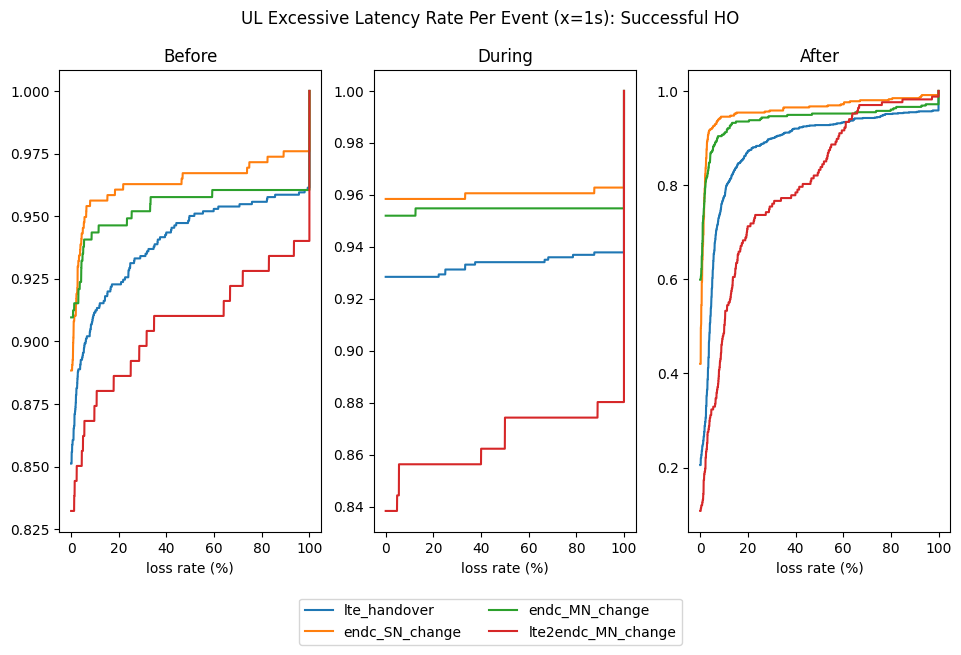

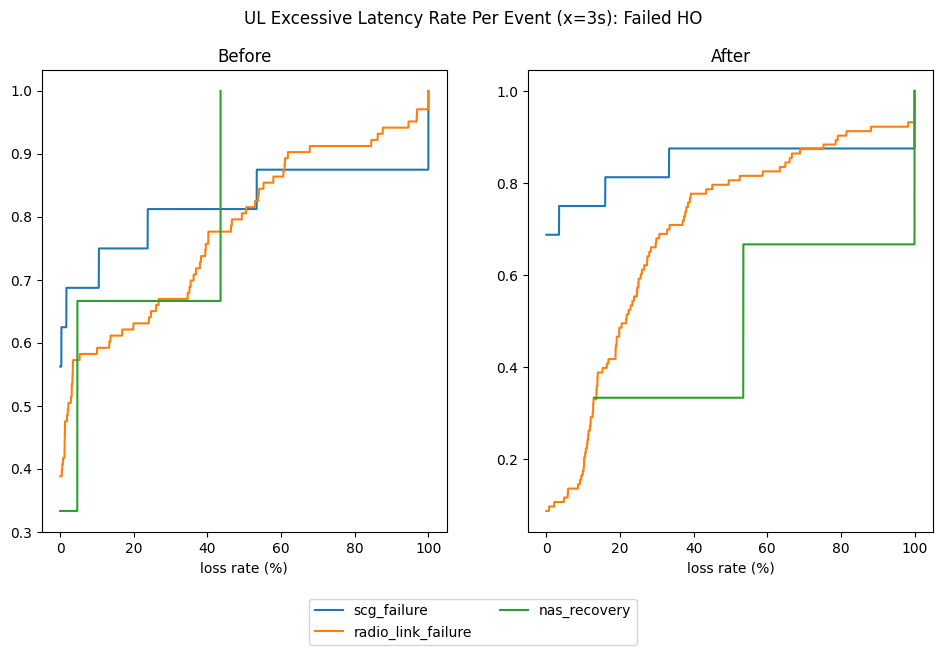

In [42]:
### ** SUCC
# fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)
# fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(11.5, 6), sharex=True)
rel = ["before", "during", "after"]
_never_occurs = set()

fig.suptitle("UL Excessive Latency Rate Per Event (x=1s): Successful HO")

labels = handover_types_0
handles = [None]*len(labels)
for i, _rel in enumerate(rel):
    ax[i].set_title(_rel.title())
    ax[i].set_xlabel("loss rate (%)")
    for j, type_name in enumerate(handover_types_0):
        # data = lodict["loss_num"]["after_lte_handover"]
        # event_name = "before_{}".format(type_name)
        event_name = "{}_{}".format(_rel, type_name)
        data1 = lodict["loss_num"][event_name]
        data2 = lodict["pkt_num"][event_name]
        data = [round(numer / (denom + 1e-9) * 100, 3) for numer, denom in zip(data1, data2)]
        if len(data) == 0:
            _never_occurs.add(type_name)
            continue
        # print(data)
        count, bins_count = np.histogram(data, bins=5000)
        # print(count, bins_count)
        pdf = count / sum(count)
        cdf = np.cumsum(pdf)
        # ax[i].plot(bins_count[1:], cdf, label=event_name)
        handles[j], = ax[i].plot(bins_count[1:], cdf)
axbox = ax[1].get_position()
# print(axbox)
labels = [item for key, item in zip(handles, labels) if key != None]
handles = [item for item in handles if item != None]
fig.legend(
    handles=handles, labels=labels,
    loc='lower center', bbox_to_anchor=[0, axbox.y0-0.2,1,1], ncol=2)
fig.savefig(os.path.join(figdir, "ulexcl_HO.png"), bbox_inches='tight')
fig.show()
print("Never Occurs:", list(_never_occurs))

### ** FAIL
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(11.5, 6), sharex=True)
rel = ["before", "after"]
_never_occurs = set()

fig.suptitle("UL Excessive Latency Rate Per Event (x=3s): Failed HO")

labels = handover_fail_types
handles = [None]*len(labels)
for i, _rel in enumerate(rel):
    ax[i].set_title(_rel.title())
    ax[i].set_xlabel("loss rate (%)")
    for j, type_name in enumerate(handover_fail_types):
        # data = lodict["loss_num"]["after_lte_handover"]
        # event_name = "before_{}".format(type_name)
        event_name = "{}_{}".format(_rel, type_name)
        data1 = lodict["loss_num"][event_name]
        data2 = lodict["pkt_num"][event_name]
        data = [round(numer / (denom + 1e-9) * 100, 3) for numer, denom in zip(data1, data2)]
        if len(data) == 0:
            _never_occurs.add(type_name)
            continue
        # print(data)
        count, bins_count = np.histogram(data, bins=5000)
        # print(count, bins_count)
        pdf = count / sum(count)
        cdf = np.cumsum(pdf)
        # ax[i].plot(bins_count[1:], cdf, label=event_name)
        handles[j], = ax[i].plot(bins_count[1:], cdf)
axbox = ax[1].get_position()
# print(axbox)
labels = [item for key, item in zip(handles, labels) if key != None]
handles = [item for item in handles if item != None]
fig.legend(
    handles=handles, labels=labels,
    loc='lower center', bbox_to_anchor=[0, axbox.y0-0.2,1,1], ncol=2)
fig.savefig(os.path.join(figdir, "ulexcl_Fail.png"), bbox_inches='tight')
fig.show()
print("Never Occurs:", list(_never_occurs))

#### CHT 8+3 types: DL Excessive Latency

In [43]:
excldatabase = "/home/wmnlab/D/database/"
exps = { "2022-12-20": 
            {  # experiment_name: (number_of_experiment_rounds, list_of_experiment_round)
                # "_Bandlock_Udp_B1_B3":  (1, ["#01",]),
                # "_Bandlock_Udp_B1_B3":  (2, ["#01", "#02",]),
                "_Bandlock_Udp_B1_B3":  (6, ["#01", "#02", "#03", "#04", "#05", "#06"]),
            },
        "2022-12-22":
            {
                "_Bandlock_Udp_B1_B3":  (3, ["#02", "#03", "#04",]),
                "_Bandlock_Udp_B3_B7":  (4, ["#01", "#02", "#03", "#04",]),
                "_Bandlock_Udp_B7_B8":  (4, ["#01", "#02", "#03", "#04",]),
                "_Bandlock_Udp_B8_B1":  (4, ["#01", "#02", "#03", "#04",]),
            },
}
# devices = ["sm05",]
# setnames = ["all",]
devices = ["sm05", "sm06", "sm07", "sm08"]
setnames = ["all", "b1", "b3", "b1b3"]

handover_types_0 = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
handover_types_1 = "SN_change_only,Intra_frequency,Inter_frequency".split(',')
handover_types_2 = "SN_change_only,Intra_sector,Intra_eNB,Inter_eNB".split(',')
handover_fail_types = "scg_failure,radio_link_failure,nas_recovery".split(',')
handover_types = handover_types_0 + handover_fail_types

first_time = 1
lodict = {}
type_names = []
for date, _exps in exps.items():
    for expr, (times, traces) in _exps.items():
        for k, (dev, stg) in enumerate(zip(devices, setnames)):
            # print('@'.join([stg, dev]))
            # print("----------------------")
            for trace in traces:
                """"""
                source_dir = os.path.join(database, date, expr, dev, trace, "statistics", "classify-bilateral")
                # df = pd.read_csv(os.path.join(source_dir, "uplk-excl", "uplk_excl_classify_1_3.csv"), index_col=0)
                df = pd.read_csv(os.path.join(source_dir, "dnlk-excl", "dnlk_excl_classify_1_3.csv"), index_col=0)
                # df = pd.read_csv(os.path.join(source_dir, "uplk-excl", "uplk_excl_classify_1.csv"), index_col=0)
                """"""
                _lodict = df.to_dict()
                if first_time:
                    lodict = _lodict
                    first_time = 0
                    type_names = list(lodict["event_occur"].keys())
                    # print(type_names)
                    for key in type_names:
                        lodict["event_dur"][key] = [float(item) for item in lodict["event_dur"][key].split('@')] if type(lodict["event_dur"][key]) == str else []
                        lodict["loss_num"][key] = [int(item) for item in lodict["loss_num"][key].split('@')] if type(lodict["loss_num"][key]) == str else []
                        lodict["pkt_num"][key] = [int(item) for item in lodict["pkt_num"][key].split('@')] if type(lodict["pkt_num"][key]) == str else []
                    continue
                for key in type_names:
                    lodict["event_occur"][key] += _lodict["event_occur"][key]
                    lodict["event_dur"][key] += [float(item) for item in _lodict["event_dur"][key].split('@')] if type(_lodict["event_dur"][key]) == str else []
                    lodict["loss_num"][key] += [int(item) for item in _lodict["loss_num"][key].split('@')] if type(_lodict["loss_num"][key]) == str else []
                    lodict["pkt_num"][key] += [int(item) for item in _lodict["pkt_num"][key].split('@')] if type(_lodict["pkt_num"][key]) == str else []
                    lodict["t_duration"][key] += _lodict["t_duration"][key]
                    lodict["t_loss_num"][key] += _lodict["t_loss_num"][key]
                    lodict["t_pkt_num"][key] += _lodict["t_pkt_num"][key]

# pprint(lodict, sort_dicts=False, width=100, compact=True)

In [44]:
column_names = []
for type_name in handover_types:
    column_names += ["before_{}".format(type_name), "during_{}".format(type_name), "after_{}".format(type_name)]
column_names += ["unstable", "stable", "overall"]
    
handover_types_0
handover_fail_types

data = {"Occurrence":{},
        "Excslat pkt number":{},
        "Proportion (%)":{},
        "Avg excslat rate (%)":{},
        "Avg excslat pkt per event":{}
        }

sum1 = 0
sum2 = 0
occ = 0
for key in handover_types_0:
    _sum1 = 0
    _sum2 = 0
    for key2 in ["before", "during", "after"]:
        _sum1 += lodict["t_loss_num"]["{}_{}".format(key2, key)]
        sum1 += lodict["t_loss_num"]["{}_{}".format(key2, key)]
        _sum2 += lodict["t_pkt_num"]["{}_{}".format(key2, key)]
        sum2 += lodict["t_pkt_num"]["{}_{}".format(key2, key)]
    _occ = lodict["event_occur"]["{}_{}".format(key2, key)]
    occ += lodict["event_occur"]["{}_{}".format(key2, key)]
    data["Occurrence"][key] = _occ
    data["Excslat pkt number"][key] = _sum1
    data["Proportion (%)"][key] = round(_sum1 / (lodict["t_loss_num"]["overall"] + 1e-9) * 100, 1)
    data["Avg excslat rate (%)"][key] = round(_sum1 / (_sum2 + 1e-9) * 100, 3) if _sum2 > 0 else '-'
    data["Avg excslat pkt per event"][key] = round(_sum1 / (_occ + 1e-9), 3) if _occ > 0 else '-'
    # print(key, _sum1, round(_sum1 / 21803 *100, 3), round(_sum1 / (_sum2 + 1e-9) *100, 3), round(_sum1 / (_occ + 1e-9), 3))
data["Occurrence"]["success"] = occ
data["Excslat pkt number"]["success"] = sum1
data["Proportion (%)"]["success"] = round(sum1 / (lodict["t_loss_num"]["overall"] + 1e-9) * 100, 1)
data["Avg excslat rate (%)"]["success"] = round(sum1 / (sum2 + 1e-9) * 100, 3) if sum2 > 0 else '-'
data["Avg excslat pkt per event"]["success"] = round(sum1 / (occ + 1e-9), 3) if occ > 0 else '-'

sum1 = 0
sum2 = 0
occ = 0
for key in handover_fail_types:
    _sum1 = 0
    _sum2 = 0
    for key2 in ["before", "during", "after"]:
        _sum1 += lodict["t_loss_num"]["{}_{}".format(key2, key)]
        sum1 += lodict["t_loss_num"]["{}_{}".format(key2, key)]
        _sum2 += lodict["t_pkt_num"]["{}_{}".format(key2, key)]
        sum2 += lodict["t_pkt_num"]["{}_{}".format(key2, key)]
    _occ = lodict["event_occur"]["{}_{}".format(key2, key)]
    occ += lodict["event_occur"]["{}_{}".format(key2, key)]
    data["Occurrence"][key] = _occ
    data["Excslat pkt number"][key] = _sum1
    data["Proportion (%)"][key] = round(_sum1 / (lodict["t_loss_num"]["overall"] + 1e-9) * 100, 1)
    data["Avg excslat rate (%)"][key] = round(_sum1 / (_sum2 + 1e-9) * 100, 3) if _sum2 > 0 else '-'
    data["Avg excslat pkt per event"][key] = round(_sum1 / (_occ + 1e-9), 3) if _occ > 0 else '-'
    # print(key, _sum1, round(_sum1 / 21803 *100, 3), round(_sum1 / (_sum2 + 1e-9) *100, 3), round(_sum1 / (_occ + 1e-9), 3))
data["Occurrence"]["fail"] = occ
data["Excslat pkt number"]["fail"] = sum1
data["Proportion (%)"]["fail"] = round(sum1 / (lodict["t_loss_num"]["overall"] + 1e-9) * 100, 3)
data["Avg excslat rate (%)"]["fail"] = round(sum1 / (sum2 + 1e-9) * 100, 1) if sum2 > 0 else '-'
data["Avg excslat pkt per event"]["fail"] = round(sum1 / (occ + 1e-9), 3) if occ > 0 else '-'

for key in ["stable", "overall"]:
    _sum1 = lodict["t_loss_num"][key]
    _sum2 = lodict["t_pkt_num"][key]
    data["Occurrence"][key] = '-'
    data["Excslat pkt number"][key] = _sum1
    data["Proportion (%)"][key] = round(_sum1 / (lodict["t_loss_num"]["overall"] + 1e-9) * 100, 1)
    data["Avg excslat rate (%)"][key] = round(_sum1 / (_sum2 + 1e-9) * 100, 3) if sum2 > 0 else '-'
    data["Avg excslat pkt per event"][key] = '-'
    # print(key, _sum1, round(_sum1 / 21803 *100, 3), round(_sum1 / (_sum2 + 1e-9) *100, 3))

df = pd.DataFrame.from_dict(data)
display(df)

row_names = handover_types_0 + ["success"] + handover_fail_types + ["fail"] + ["stable", "overall"]
for row in row_names:
    print(*list(df.loc[row]), sep=',')

,Occurrence,Excslat pkt number,Proportion (%),Avg excslat rate (%),Avg excslat pkt per event
lte_handover,1062,21320,24.700,2.284,20.075
SN_addition,0,0,0.000,-,-
SN_removal,0,0,0.000,-,-
endc_SN_change,457,3503,4.100,0.902,7.665
endc_MN_change,354,2220,2.600,0.804,6.271
endc_MNSN_change,0,0,0.000,-,-
lte2endc_MN_change,167,6930,8.000,8.735,41.497
endc2lte_MN_change,0,0,0.000,-,-
success,2040,33973,39.300,2.025,16.653
scg_failure,16,109,0.100,0.645,6.812


1062,21320,24.7,2.284,20.075
0,0,0.0,-,-
0,0,0.0,-,-
457,3503,4.1,0.902,7.665
354,2220,2.6,0.804,6.271
0,0,0.0,-,-
167,6930,8.0,8.735,41.497
0,0,0.0,-,-
2040,33973,39.3,2.025,16.653
16,109,0.1,0.645,6.812
103,18387,21.3,12.359,178.515
3,250,0.3,7.379,83.333
122,18746,21.675,11.1,153.656
-,33767,39.0,0.251,-
-,86486,100.0,0.565,-


Never Occurs: ['endc_MNSN_change', 'SN_removal', 'endc2lte_MN_change', 'SN_addition']
Never Occurs: []


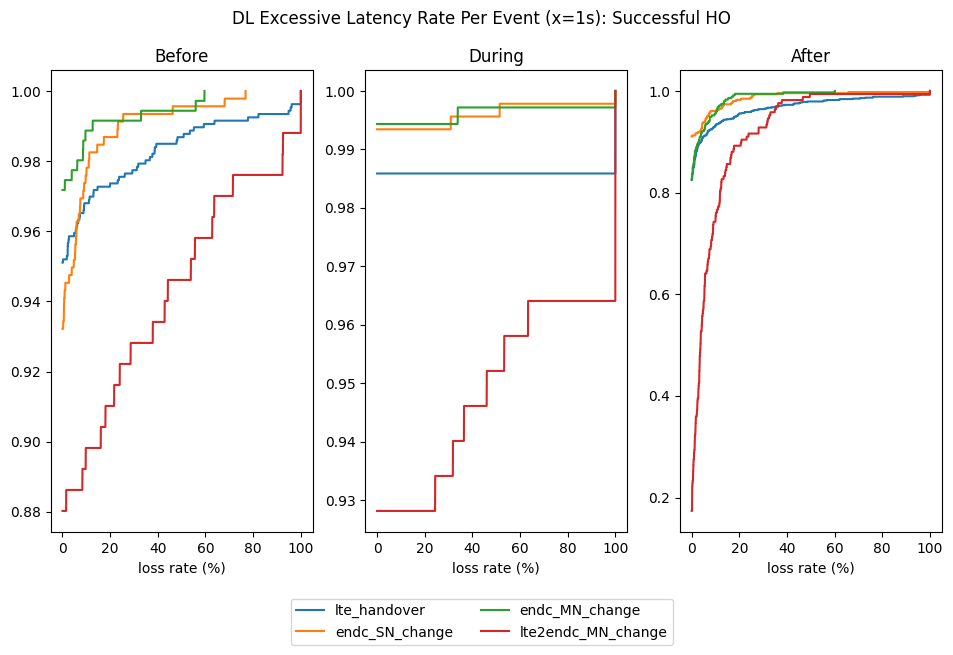

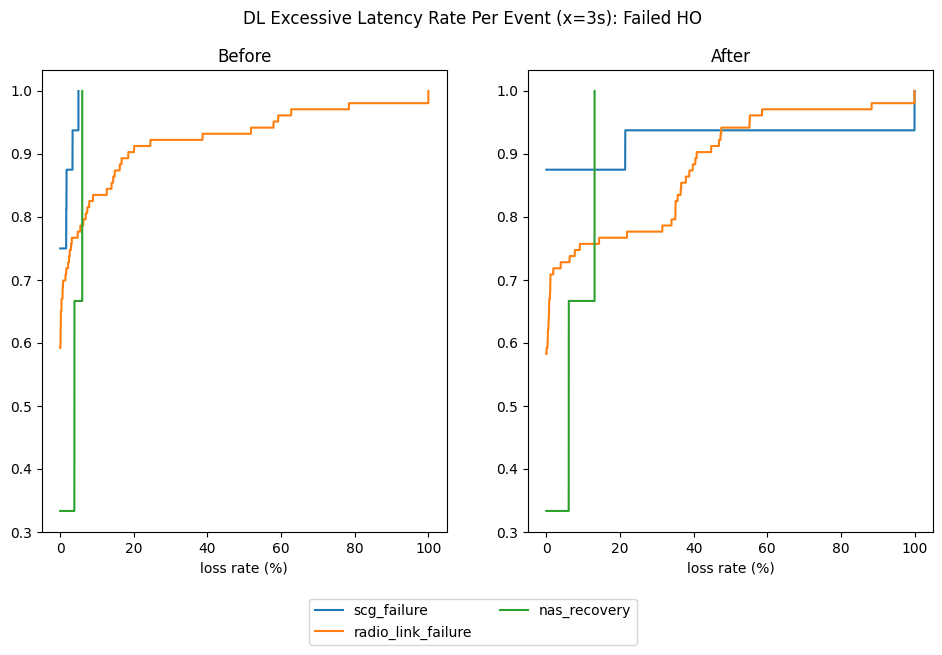

In [45]:
### ** SUCC
# fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)
# fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(11.5, 6), sharex=True)
rel = ["before", "during", "after"]
_never_occurs = set()

fig.suptitle("DL Excessive Latency Rate Per Event (x=1s): Successful HO")

labels = handover_types_0
handles = [None]*len(labels)
for i, _rel in enumerate(rel):
    ax[i].set_title(_rel.title())
    ax[i].set_xlabel("loss rate (%)")
    for j, type_name in enumerate(handover_types_0):
        # data = lodict["loss_num"]["after_lte_handover"]
        # event_name = "before_{}".format(type_name)
        event_name = "{}_{}".format(_rel, type_name)
        data1 = lodict["loss_num"][event_name]
        data2 = lodict["pkt_num"][event_name]
        data = [round(numer / (denom + 1e-9) * 100, 3) for numer, denom in zip(data1, data2)]
        if len(data) == 0:
            _never_occurs.add(type_name)
            continue
        # print(data)
        count, bins_count = np.histogram(data, bins=5000)
        # print(count, bins_count)
        pdf = count / sum(count)
        cdf = np.cumsum(pdf)
        # ax[i].plot(bins_count[1:], cdf, label=event_name)
        handles[j], = ax[i].plot(bins_count[1:], cdf)
axbox = ax[1].get_position()
# print(axbox)
labels = [item for key, item in zip(handles, labels) if key != None]
handles = [item for item in handles if item != None]
fig.legend(
    handles=handles, labels=labels,
    loc='lower center', bbox_to_anchor=[0, axbox.y0-0.2,1,1], ncol=2)
fig.savefig(os.path.join(figdir, "dlexcl_HO.png"), bbox_inches='tight')
fig.show()
print("Never Occurs:", list(_never_occurs))

### ** FAIL
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(11.5, 6), sharex=True)
rel = ["before", "after"]
_never_occurs = set()

fig.suptitle("DL Excessive Latency Rate Per Event (x=3s): Failed HO")

labels = handover_fail_types
handles = [None]*len(labels)
for i, _rel in enumerate(rel):
    ax[i].set_title(_rel.title())
    ax[i].set_xlabel("loss rate (%)")
    for j, type_name in enumerate(handover_fail_types):
        # data = lodict["loss_num"]["after_lte_handover"]
        # event_name = "before_{}".format(type_name)
        event_name = "{}_{}".format(_rel, type_name)
        data1 = lodict["loss_num"][event_name]
        data2 = lodict["pkt_num"][event_name]
        data = [round(numer / (denom + 1e-9) * 100, 3) for numer, denom in zip(data1, data2)]
        if len(data) == 0:
            _never_occurs.add(type_name)
            continue
        # print(data)
        count, bins_count = np.histogram(data, bins=5000)
        # print(count, bins_count)
        pdf = count / sum(count)
        cdf = np.cumsum(pdf)
        # ax[i].plot(bins_count[1:], cdf, label=event_name)
        handles[j], = ax[i].plot(bins_count[1:], cdf)
axbox = ax[1].get_position()
# print(axbox)
labels = [item for key, item in zip(handles, labels) if key != None]
handles = [item for item in handles if item != None]
fig.legend(
    handles=handles, labels=labels,
    loc='lower center', bbox_to_anchor=[0, axbox.y0-0.2,1,1], ncol=2)
fig.savefig(os.path.join(figdir, "dlexcl_Fail.png"), bbox_inches='tight')
fig.show()
print("Never Occurs:", list(_never_occurs))

#### CHT 8+3 types / 4 schemes: UL Excessive Latency

In [67]:
database = "/home/wmnlab/D/database/"
exps = {
        # "2022-12-20": 
        #     {  # experiment_name: (number_of_experiment_rounds, list_of_experiment_round)
        #         # "_Bandlock_Udp_B1_B3":  (1, ["#01",]),
        #         # "_Bandlock_Udp_B1_B3":  (2, ["#01", "#02",]),
        #         "_Bandlock_Udp_B1_B3":  (6, ["#01", "#02", "#03", "#04", "#05", "#06"]),
        #     },
        "2022-12-22":
            {
                # "_Bandlock_Udp_B1_B3":  (3, ["#02", "#03", "#04",]),
                # "_Bandlock_Udp_B3_B7":  (4, ["#01", "#02", "#03", "#04",]),
                # "_Bandlock_Udp_B7_B8":  (4, ["#01", "#02", "#03", "#04",]),
                "_Bandlock_Udp_B8_B1":  (4, ["#01", "#02", "#03", "#04",]),
            },
}
# devices = ["sm05",]
# setnames = ["all",]
devices = ["sm05", "sm06", "sm07", "sm08"]
# setnames = ["all", "b1", "b3", "b1b3"]
# setnames = ["all", "b3", "b7", "b3b7"]
# setnames = ["all", "b7", "b8", "b7b8"]
setnames = ["all", "b8", "b1", "b8b1"]

handover_types_0 = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
handover_types_1 = "SN_change_only,Intra_frequency,Inter_frequency".split(',')
handover_types_2 = "SN_change_only,Intra_sector,Intra_eNB,Inter_eNB".split(',')
handover_fail_types = "scg_failure,radio_link_failure,nas_recovery".split(',')
handover_types = handover_types_0 + handover_fail_types

# first_time = 1
lodicts = [{}, {}, {}, {}]
lodict = {}
type_names = []
for date, _exps in exps.items():
    for expr, (times, traces) in _exps.items():
        for k, (dev, stg) in enumerate(zip(devices, setnames)):
            # lodict = lodicts[k]
            # print(lodict)
            print('@'.join([stg, dev]))
            print("----------------------")
            first_time = 1
            for trace in traces:
                """"""
                source_dir = os.path.join(database, date, expr, dev, trace, "statistics", "classify-bilateral")
                df = pd.read_csv(os.path.join(source_dir, "uplk-excl", "uplk_excl_classify_1_3.csv"), index_col=0)
                # df = pd.read_csv(os.path.join(source_dir, "dnlk-excl", "dnlk_excl_classify_1_3.csv"), index_col=0)
                # df = pd.read_csv(os.path.join(source_dir, "uplk-excl", "uplk_excl_classify_1.csv"), index_col=0)
                """"""
                _lodict = df.to_dict()
                if first_time:
                    # print(lodicts[k])
                    lodicts[k] = _lodict
                    first_time = 0
                    type_names = list(lodicts[k]["event_occur"].keys())
                    # print(type_names)
                    for key in type_names:
                        lodicts[k]["event_dur"][key] = [float(item) for item in lodicts[k]["event_dur"][key].split('@')] if type(lodicts[k]["event_dur"][key]) == str else []
                        lodicts[k]["loss_num"][key] = [int(item) for item in lodicts[k]["loss_num"][key].split('@')] if type(lodicts[k]["loss_num"][key]) == str else []
                        lodicts[k]["pkt_num"][key] = [int(item) for item in lodicts[k]["pkt_num"][key].split('@')] if type(lodicts[k]["pkt_num"][key]) == str else []
                    continue
                for key in type_names:
                    lodicts[k]["event_occur"][key] += _lodict["event_occur"][key]
                    lodicts[k]["event_dur"][key] += [float(item) for item in _lodict["event_dur"][key].split('@')] if type(_lodict["event_dur"][key]) == str else []
                    lodicts[k]["loss_num"][key] += [int(item) for item in _lodict["loss_num"][key].split('@')] if type(_lodict["loss_num"][key]) == str else []
                    lodicts[k]["pkt_num"][key] += [int(item) for item in _lodict["pkt_num"][key].split('@')] if type(_lodict["pkt_num"][key]) == str else []
                    lodicts[k]["t_duration"][key] += _lodict["t_duration"][key]
                    lodicts[k]["t_loss_num"][key] += _lodict["t_loss_num"][key]
                    lodicts[k]["t_pkt_num"][key] += _lodict["t_pkt_num"][key]

pprint(lodicts, sort_dicts=False, width=100, compact=True)

all@sm05
----------------------
b8@sm06
----------------------
b1@sm07
----------------------
b8b1@sm08
----------------------
[{'event_occur': {'before_lte_handover': 55,
                  'during_lte_handover': 55,
                  'after_lte_handover': 55,
                  'before_SN_addition': 0,
                  'during_SN_addition': 0,
                  'after_SN_addition': 0,
                  'before_SN_removal': 0,
                  'during_SN_removal': 0,
                  'after_SN_removal': 0,
                  'before_endc_SN_change': 10,
                  'during_endc_SN_change': 10,
                  'after_endc_SN_change': 10,
                  'before_endc_MN_change': 10,
                  'during_endc_MN_change': 10,
                  'after_endc_MN_change': 10,
                  'before_endc_MNSN_change': 0,
                  'during_endc_MNSN_change': 0,
                  'after_endc_MNSN_change': 0,
                  'before_lte2endc_MN_change': 5,
             

In [68]:
column_names = []
for type_name in handover_types:
    column_names += ["before_{}".format(type_name), "during_{}".format(type_name), "after_{}".format(type_name)]
column_names += ["unstable", "stable", "overall"]
handover_types_0
handover_fail_types

for k, (dev, stg) in enumerate(zip(devices, setnames)):
    print('@'.join([stg, dev]))
    data = {"Occurrence":{},
        "Excslat pkt number":{},
        "Proportion (%)":{},
        "Avg excslat rate (%)":{},
        "Avg excslat pkt per event":{}
        }

    sum1 = 0
    sum2 = 0
    occ = 0
    for key in handover_types_0:
        _sum1 = 0
        _sum2 = 0
        for key2 in ["before", "during", "after"]:
            _sum1 += lodicts[k]["t_loss_num"]["{}_{}".format(key2, key)]
            sum1 += lodicts[k]["t_loss_num"]["{}_{}".format(key2, key)]
            _sum2 += lodicts[k]["t_pkt_num"]["{}_{}".format(key2, key)]
            sum2 += lodicts[k]["t_pkt_num"]["{}_{}".format(key2, key)]
        _occ = lodicts[k]["event_occur"]["{}_{}".format(key2, key)]
        occ += lodicts[k]["event_occur"]["{}_{}".format(key2, key)]
        data["Occurrence"][key] = _occ
        data["Excslat pkt number"][key] = _sum1
        data["Proportion (%)"][key] = round(_sum1 / (lodicts[k]["t_loss_num"]["overall"] + 1e-9) * 100, 1)
        data["Avg excslat rate (%)"][key] = round(_sum1 / (_sum2 + 1e-9) * 100, 3) if _sum2 > 0 else '-'
        data["Avg excslat pkt per event"][key] = round(_sum1 / (_occ + 1e-9), 3) if _occ > 0 else '-'
        # print(key, _sum1, round(_sum1 / 21803 *100, 3), round(_sum1 / (_sum2 + 1e-9) *100, 3), round(_sum1 / (_occ + 1e-9), 3))
    data["Occurrence"]["success"] = occ
    data["Excslat pkt number"]["success"] = sum1
    data["Proportion (%)"]["success"] = round(sum1 / (lodicts[k]["t_loss_num"]["overall"] + 1e-9) * 100, 1)
    data["Avg excslat rate (%)"]["success"] = round(sum1 / (sum2 + 1e-9) * 100, 3) if sum2 > 0 else '-'
    data["Avg excslat pkt per event"]["success"] = round(sum1 / (occ + 1e-9), 3) if occ > 0 else '-'

    sum1 = 0
    sum2 = 0
    occ = 0
    for key in handover_fail_types:
        _sum1 = 0
        _sum2 = 0
        for key2 in ["before", "during", "after"]:
            _sum1 += lodicts[k]["t_loss_num"]["{}_{}".format(key2, key)]
            sum1 += lodicts[k]["t_loss_num"]["{}_{}".format(key2, key)]
            _sum2 += lodicts[k]["t_pkt_num"]["{}_{}".format(key2, key)]
            sum2 += lodicts[k]["t_pkt_num"]["{}_{}".format(key2, key)]
        _occ = lodicts[k]["event_occur"]["{}_{}".format(key2, key)]
        occ += lodicts[k]["event_occur"]["{}_{}".format(key2, key)]
        data["Occurrence"][key] = _occ
        data["Excslat pkt number"][key] = _sum1
        data["Proportion (%)"][key] = round(_sum1 / (lodicts[k]["t_loss_num"]["overall"] + 1e-9) * 100, 1)
        data["Avg excslat rate (%)"][key] = round(_sum1 / (_sum2 + 1e-9) * 100, 3) if _sum2 > 0 else '-'
        data["Avg excslat pkt per event"][key] = round(_sum1 / (_occ + 1e-9), 3) if _occ > 0 else '-'
        # print(key, _sum1, round(_sum1 / 21803 *100, 3), round(_sum1 / (_sum2 + 1e-9) *100, 3), round(_sum1 / (_occ + 1e-9), 3))
    data["Occurrence"]["fail"] = occ
    data["Excslat pkt number"]["fail"] = sum1
    data["Proportion (%)"]["fail"] = round(sum1 / (lodicts[k]["t_loss_num"]["overall"] + 1e-9) * 100, 3)
    data["Avg excslat rate (%)"]["fail"] = round(sum1 / (sum2 + 1e-9) * 100, 1) if sum2 > 0 else '-'
    data["Avg excslat pkt per event"]["fail"] = round(sum1 / (occ + 1e-9), 3) if occ > 0 else '-'

    for key in ["stable", "overall"]:
        _sum1 = lodicts[k]["t_loss_num"][key]
        _sum2 = lodicts[k]["t_pkt_num"][key]
        data["Occurrence"][key] = '-'
        data["Excslat pkt number"][key] = _sum1
        data["Proportion (%)"][key] = round(_sum1 / (lodicts[k]["t_loss_num"]["overall"] + 1e-9) * 100, 1)
        data["Avg excslat rate (%)"][key] = round(_sum1 / (_sum2 + 1e-9) * 100, 3) if sum2 > 0 else '-'
        data["Avg excslat pkt per event"][key] = '-'
        # print(key, _sum1, round(_sum1 / 21803 *100, 3), round(_sum1 / (_sum2 + 1e-9) *100, 3))

    df = pd.DataFrame.from_dict(data)
    display(df)
    if k == 0:
        dfs = df
    else:
        dfs = pd.concat([dfs, df], axis=1)

display(dfs)
row_names = handover_types_0 + ["success"] + handover_fail_types + ["fail"] + ["stable", "overall"]
for row in row_names:
    print(*list(dfs.loc[row]), sep=',')

all@sm05


,Occurrence,Excslat pkt number,Proportion (%),Avg excslat rate (%),Avg excslat pkt per event
lte_handover,55,6738,23.900,13.731,122.509
SN_addition,0,0,0.000,-,-
SN_removal,0,0,0.000,-,-
endc_SN_change,10,113,0.400,1.415,11.3
endc_MN_change,10,122,0.400,1.406,12.2
endc_MNSN_change,0,0,0.000,-,-
lte2endc_MN_change,5,617,2.200,21.702,123.4
endc2lte_MN_change,0,0,0.000,-,-
success,80,7590,27.000,11.068,94.875
scg_failure,2,0,0.000,0.0,0.0


b8@sm06


,Occurrence,Excslat pkt number,Proportion (%),Avg excslat rate (%),Avg excslat pkt per event
lte_handover,88,16677,19.900,19.061,189.511
SN_addition,0,0,0.000,-,-
SN_removal,0,0,0.000,-,-
endc_SN_change,0,0,0.000,-,-
endc_MN_change,0,0,0.000,-,-
endc_MNSN_change,0,0,0.000,-,-
lte2endc_MN_change,0,0,0.000,-,-
endc2lte_MN_change,0,0,0.000,-,-
success,88,16677,19.900,19.061,189.511
scg_failure,0,0,0.000,-,-


b1@sm07


,Occurrence,Excslat pkt number,Proportion (%),Avg excslat rate (%),Avg excslat pkt per event
lte_handover,53,1870,31.300,3.592,35.283
SN_addition,0,0,0.000,-,-
SN_removal,0,0,0.000,-,-
endc_SN_change,0,0,0.000,-,-
endc_MN_change,0,0,0.000,-,-
endc_MNSN_change,0,0,0.000,-,-
lte2endc_MN_change,0,0,0.000,-,-
endc2lte_MN_change,0,0,0.000,-,-
success,53,1870,31.300,3.592,35.283
scg_failure,0,0,0.000,-,-


b8b1@sm08


,Occurrence,Excslat pkt number,Proportion (%),Avg excslat rate (%),Avg excslat pkt per event
lte_handover,51,1849,46.700,3.924,36.255
SN_addition,0,0,0.000,-,-
SN_removal,0,0,0.000,-,-
endc_SN_change,0,0,0.000,-,-
endc_MN_change,0,0,0.000,-,-
endc_MNSN_change,0,0,0.000,-,-
lte2endc_MN_change,0,0,0.000,-,-
endc2lte_MN_change,0,0,0.000,-,-
success,51,1849,46.700,3.924,36.255
scg_failure,0,0,0.000,-,-


,Occurrence,Excslat pkt number,Proportion (%),Avg excslat rate (%),Avg excslat pkt per event,Occurrence,Excslat pkt number,Proportion (%),Avg excslat rate (%),Avg excslat pkt per event,Occurrence,Excslat pkt number,Proportion (%),Avg excslat rate (%),Avg excslat pkt per event,Occurrence,Excslat pkt number,Proportion (%),Avg excslat rate (%),Avg excslat pkt per event
lte_handover,55,6738,23.900,13.731,122.509,88,16677,19.900,19.061,189.511,53,1870,31.300,3.592,35.283,51,1849,46.700,3.924,36.255
SN_addition,0,0,0.000,-,-,0,0,0.000,-,-,0,0,0.000,-,-,0,0,0.000,-,-
SN_removal,0,0,0.000,-,-,0,0,0.000,-,-,0,0,0.000,-,-,0,0,0.000,-,-
endc_SN_change,10,113,0.400,1.415,11.3,0,0,0.000,-,-,0,0,0.000,-,-,0,0,0.000,-,-
endc_MN_change,10,122,0.400,1.406,12.2,0,0,0.000,-,-,0,0,0.000,-,-,0,0,0.000,-,-
endc_MNSN_change,0,0,0.000,-,-,0,0,0.000,-,-,0,0,0.000,-,-,0,0,0.000,-,-
lte2endc_MN_change,5,617,2.200,21.702,123.4,0,0,0.000,-,-,0,0,0.000,-,-,0,0,0.000,-,-
endc2lte_MN_change,0,0,0.000,-,-,0,0,0.000,-,-,0,0,0.000,-,-,0,0,0.000,-,-
success,80,7590,27.000,11.068,94.875,88,16677,19.900,19.061,189.511,53,1870,31.300,3.592,35.283,51,1849,46.700,3.924,36.255
scg_failure,2,0,0.000,0.0,0.0,0,0,0.000,-,-,0,0,0.000,-,-,0,0,0.000,-,-


55,6738,23.9,13.731,122.509,88,16677,19.9,19.061,189.511,53,1870,31.3,3.592,35.283,51,1849,46.7,3.924,36.255
0,0,0.0,-,-,0,0,0.0,-,-,0,0,0.0,-,-,0,0,0.0,-,-
0,0,0.0,-,-,0,0,0.0,-,-,0,0,0.0,-,-,0,0,0.0,-,-
10,113,0.4,1.415,11.3,0,0,0.0,-,-,0,0,0.0,-,-,0,0,0.0,-,-
10,122,0.4,1.406,12.2,0,0,0.0,-,-,0,0,0.0,-,-,0,0,0.0,-,-
0,0,0.0,-,-,0,0,0.0,-,-,0,0,0.0,-,-,0,0,0.0,-,-
5,617,2.2,21.702,123.4,0,0,0.0,-,-,0,0,0.0,-,-,0,0,0.0,-,-
0,0,0.0,-,-,0,0,0.0,-,-,0,0,0.0,-,-,0,0,0.0,-,-
80,7590,27.0,11.068,94.875,88,16677,19.9,19.061,189.511,53,1870,31.3,3.592,35.283,51,1849,46.7,3.924,36.255
2,0,0.0,0.0,0.0,0,0,0.0,-,-,0,0,0.0,-,-,0,0,0.0,-,-
7,4450,15.8,26.883,635.714,2,2045,2.4,42.41,1022.5,0,0,0.0,-,-,1,321,8.1,12.456,321.0
0,0,0.0,-,-,0,0,0.0,-,-,1,3119,52.1,100.0,3119.0,1,1102,27.8,49.797,1102.0
9,4450,15.816,22.7,494.444,2,2045,2.445,42.4,1022.5,1,3119,52.131,100.0,3119.0,2,1423,35.934,29.7,711.5
-,16096,57.2,2.834,-,-,64928,77.6,11.56,-,-,994,16.6,0.166,-,-,688,17.4,0.114,-
-,28136,100.0,4.289

Never Occurs: ['SN_addition', 'endc_SN_change', 'endc_MNSN_change', 'lte2endc_MN_change', 'SN_removal', 'endc2lte_MN_change', 'endc_MN_change']
Never Occurs: ['nas_recovery', 'scg_failure', 'radio_link_failure']


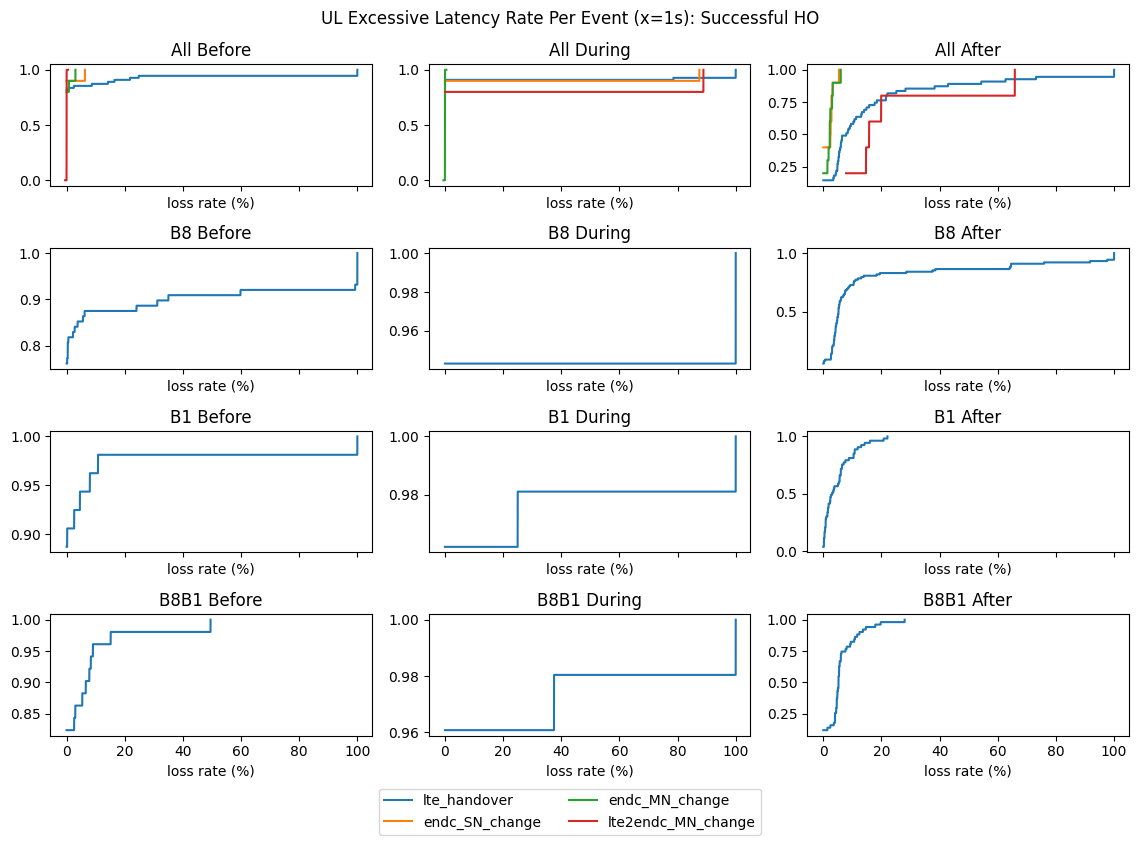

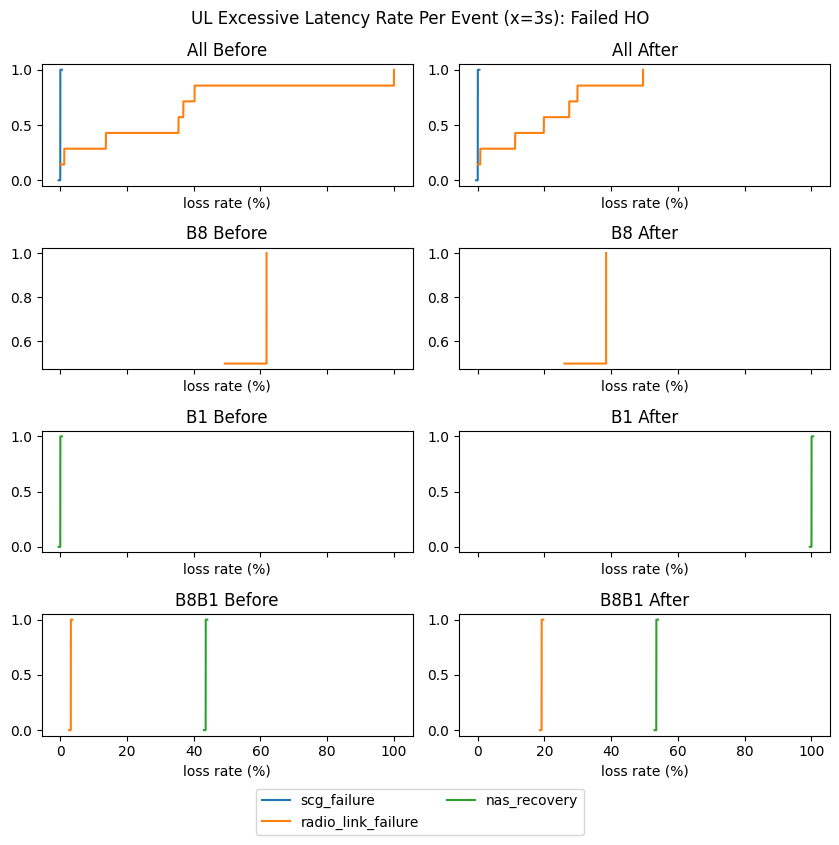

In [69]:
### ** SUCC
# fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)
# fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(11.5, 8), sharex=True)
rel = ["before", "during", "after"]
_never_occurs = set()

fig.suptitle("UL Excessive Latency Rate Per Event (x=1s): Successful HO")

labels = handover_types_0
handles = [None]*len(labels)
# cmap = plt.cm.get_cmap('gist_rainbow', len(labels))
# colors = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
# colors = list(mcolors.TABLEAU_COLORS.keys())
colors = ['tab:blue', 'tab:purple', 'tab:brown', 'tab:orange', 'tab:green', 'tab:pink', 'tab:red', 'tab:gray', 'tab:olive', 'tab:cyan']
for k, (dev, stg) in enumerate(zip(devices, setnames)):
    for i, _rel in enumerate(rel):
        ax[k, i].set_title("{} {}".format(stg, _rel).title())
        ax[k, i].set_xlabel("loss rate (%)")
        for j, type_name in enumerate(handover_types_0):
            # data = lodicts[k]["loss_num"]["after_lte_handover"]
            # event_name = "before_{}".format(type_name)
            event_name = "{}_{}".format(_rel, type_name)
            data1 = lodicts[k]["loss_num"][event_name]
            data2 = lodicts[k]["pkt_num"][event_name]
            data = [round(numer / (denom + 1e-9) * 100, 3) for numer, denom in zip(data1, data2)]
            if len(data) == 0:
                _never_occurs.add(type_name)
                continue
            # print(data)
            count, bins_count = np.histogram(data, bins=5000)
            # print(count, bins_count)
            pdf = count / sum(count)
            cdf = np.cumsum(pdf)
            # ax[k, i].plot(bins_count[1:], cdf, label=event_name)
            handles[j], = ax[k, i].plot(bins_count[1:], cdf, c=colors[j])
axbox = ax[3, 1].get_position()
# print(axbox)
labels = [item for key, item in zip(handles, labels) if key != None]
handles = [item for item in handles if item != None]
fig.legend(
    handles=handles, labels=labels,
    loc='lower center', bbox_to_anchor=[0, axbox.y0-0.17,1,1], ncol=2)
fig.tight_layout()
fig.savefig(os.path.join(figdir, "ulexcl_HO_{}.png".format(setnames[3])), bbox_inches='tight')
fig.show()
print("Never Occurs:", list(_never_occurs))

### ** FAIL
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(8.5, 8), sharex=True)
rel = ["before", "after"]
_never_occurs = set()

fig.suptitle("UL Excessive Latency Rate Per Event (x=3s): Failed HO")

labels = handover_fail_types
handles = [None]*len(labels)
# cmap = plt.cm.get_cmap('gist_rainbow', len(labels))
# colors = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
# colors = list(mcolors.TABLEAU_COLORS.keys())
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
for k, (dev, stg) in enumerate(zip(devices, setnames)):
    for i, _rel in enumerate(rel):
        ax[k, i].set_title("{} {}".format(stg, _rel).title())
        ax[k, i].set_xlabel("loss rate (%)")
        for j, type_name in enumerate(handover_fail_types):
            # data = lodicts[k]["loss_num"]["after_lte_handover"]
            # event_name = "before_{}".format(type_name)
            event_name = "{}_{}".format(_rel, type_name)
            data1 = lodicts[k]["loss_num"][event_name]
            data2 = lodicts[k]["pkt_num"][event_name]
            data = [round(numer / (denom + 1e-9) * 100, 3) for numer, denom in zip(data1, data2)]
            if len(data) == 0:
                _never_occurs.add(type_name)
                continue
            # print(data)
            count, bins_count = np.histogram(data, bins=5000)
            # print(count, bins_count)
            pdf = count / sum(count)
            cdf = np.cumsum(pdf)
            # ax[k, i].plot(bins_count[1:], cdf, label=event_name)
            handles[j], = ax[k, i].plot(bins_count[1:], cdf, c=colors[j])
axbox = ax[3, 1].get_position()
# print(axbox)
labels = [item for key, item in zip(handles, labels) if key != None]
handles = [item for item in handles if item != None]
fig.legend(
    handles=handles, labels=labels,
    loc='lower center', bbox_to_anchor=[0, axbox.y0-0.17,1,1], ncol=2)
fig.tight_layout()
fig.savefig(os.path.join(figdir, "ulexcl_Fail_{}.png".format(setnames[3])), bbox_inches='tight')
fig.show()
print("Never Occurs:", list(_never_occurs))

#### CHT 8+3 types / 4 schemes: DL Excessive Latency

In [70]:
excldatabase = "/home/wmnlab/D/database/"
exps = {
        # "2022-12-20": 
        #     {  # experiment_name: (number_of_experiment_rounds, list_of_experiment_round)
        #         # "_Bandlock_Udp_B1_B3":  (1, ["#01",]),
        #         # "_Bandlock_Udp_B1_B3":  (2, ["#01", "#02",]),
        #         "_Bandlock_Udp_B1_B3":  (6, ["#01", "#02", "#03", "#04", "#05", "#06"]),
        #     },
        "2022-12-22":
            {
                # "_Bandlock_Udp_B1_B3":  (3, ["#02", "#03", "#04",]),
                # "_Bandlock_Udp_B3_B7":  (4, ["#01", "#02", "#03", "#04",]),
                # "_Bandlock_Udp_B7_B8":  (4, ["#01", "#02", "#03", "#04",]),
                "_Bandlock_Udp_B8_B1":  (4, ["#01", "#02", "#03", "#04",]),
            },
}
# devices = ["sm05",]
# setnames = ["all",]
devices = ["sm05", "sm06", "sm07", "sm08"]
# setnames = ["all", "b1", "b3", "b1b3"]
# setnames = ["all", "b3", "b7", "b3b7"]
# setnames = ["all", "b7", "b8", "b7b8"]
setnames = ["all", "b8", "b1", "b8b1"]

handover_types_0 = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
handover_types_1 = "SN_change_only,Intra_frequency,Inter_frequency".split(',')
handover_types_2 = "SN_change_only,Intra_sector,Intra_eNB,Inter_eNB".split(',')
handover_fail_types = "scg_failure,radio_link_failure,nas_recovery".split(',')
handover_types = handover_types_0 + handover_fail_types

# first_time = 1
lodicts = [{}, {}, {}, {}]
lodict = {}
type_names = []
for date, _exps in exps.items():
    for expr, (times, traces) in _exps.items():
        for k, (dev, stg) in enumerate(zip(devices, setnames)):
            # lodict = lodicts[k]
            # print(lodict)
            print('@'.join([stg, dev]))
            print("----------------------")
            first_time = 1
            for trace in traces:
                """"""
                source_dir = os.path.join(database, date, expr, dev, trace, "statistics", "classify-bilateral")
                # df = pd.read_csv(os.path.join(source_dir, "uplk-excl", "uplk_excl_classify_1_3.csv"), index_col=0)
                df = pd.read_csv(os.path.join(source_dir, "dnlk-excl", "dnlk_excl_classify_1_3.csv"), index_col=0)
                # df = pd.read_csv(os.path.join(source_dir, "uplk-excl", "uplk_excl_classify_1.csv"), index_col=0)
                """"""
                _lodict = df.to_dict()
                if first_time:
                    # print(lodicts[k])
                    lodicts[k] = _lodict
                    first_time = 0
                    type_names = list(lodicts[k]["event_occur"].keys())
                    # print(type_names)
                    for key in type_names:
                        lodicts[k]["event_dur"][key] = [float(item) for item in lodicts[k]["event_dur"][key].split('@')] if type(lodicts[k]["event_dur"][key]) == str else []
                        lodicts[k]["loss_num"][key] = [int(item) for item in lodicts[k]["loss_num"][key].split('@')] if type(lodicts[k]["loss_num"][key]) == str else []
                        lodicts[k]["pkt_num"][key] = [int(item) for item in lodicts[k]["pkt_num"][key].split('@')] if type(lodicts[k]["pkt_num"][key]) == str else []
                    continue
                for key in type_names:
                    lodicts[k]["event_occur"][key] += _lodict["event_occur"][key]
                    lodicts[k]["event_dur"][key] += [float(item) for item in _lodict["event_dur"][key].split('@')] if type(_lodict["event_dur"][key]) == str else []
                    lodicts[k]["loss_num"][key] += [int(item) for item in _lodict["loss_num"][key].split('@')] if type(_lodict["loss_num"][key]) == str else []
                    lodicts[k]["pkt_num"][key] += [int(item) for item in _lodict["pkt_num"][key].split('@')] if type(_lodict["pkt_num"][key]) == str else []
                    lodicts[k]["t_duration"][key] += _lodict["t_duration"][key]
                    lodicts[k]["t_loss_num"][key] += _lodict["t_loss_num"][key]
                    lodicts[k]["t_pkt_num"][key] += _lodict["t_pkt_num"][key]

# pprint(lodicts, sort_dicts=False, width=100, compact=True)

all@sm05
----------------------
b8@sm06
----------------------
b1@sm07
----------------------
b8b1@sm08
----------------------


In [71]:
column_names = []
for type_name in handover_types:
    column_names += ["before_{}".format(type_name), "during_{}".format(type_name), "after_{}".format(type_name)]
column_names += ["unstable", "stable", "overall"]
handover_types_0
handover_fail_types

for k, (dev, stg) in enumerate(zip(devices, setnames)):
    print('@'.join([stg, dev]))
    data = {"Occurrence":{},
        "Excslat pkt number":{},
        "Proportion (%)":{},
        "Avg excslat rate (%)":{},
        "Avg excslat pkt per event":{}
        }

    sum1 = 0
    sum2 = 0
    occ = 0
    for key in handover_types_0:
        _sum1 = 0
        _sum2 = 0
        for key2 in ["before", "during", "after"]:
            _sum1 += lodicts[k]["t_loss_num"]["{}_{}".format(key2, key)]
            sum1 += lodicts[k]["t_loss_num"]["{}_{}".format(key2, key)]
            _sum2 += lodicts[k]["t_pkt_num"]["{}_{}".format(key2, key)]
            sum2 += lodicts[k]["t_pkt_num"]["{}_{}".format(key2, key)]
        _occ = lodicts[k]["event_occur"]["{}_{}".format(key2, key)]
        occ += lodicts[k]["event_occur"]["{}_{}".format(key2, key)]
        data["Occurrence"][key] = _occ
        data["Excslat pkt number"][key] = _sum1
        data["Proportion (%)"][key] = round(_sum1 / (lodicts[k]["t_loss_num"]["overall"] + 1e-9) * 100, 1)
        data["Avg excslat rate (%)"][key] = round(_sum1 / (_sum2 + 1e-9) * 100, 3) if _sum2 > 0 else '-'
        data["Avg excslat pkt per event"][key] = round(_sum1 / (_occ + 1e-9), 3) if _occ > 0 else '-'
        # print(key, _sum1, round(_sum1 / 21803 *100, 3), round(_sum1 / (_sum2 + 1e-9) *100, 3), round(_sum1 / (_occ + 1e-9), 3))
    data["Occurrence"]["success"] = occ
    data["Excslat pkt number"]["success"] = sum1
    data["Proportion (%)"]["success"] = round(sum1 / (lodicts[k]["t_loss_num"]["overall"] + 1e-9) * 100, 1)
    data["Avg excslat rate (%)"]["success"] = round(sum1 / (sum2 + 1e-9) * 100, 3) if sum2 > 0 else '-'
    data["Avg excslat pkt per event"]["success"] = round(sum1 / (occ + 1e-9), 3) if occ > 0 else '-'

    sum1 = 0
    sum2 = 0
    occ = 0
    for key in handover_fail_types:
        _sum1 = 0
        _sum2 = 0
        for key2 in ["before", "during", "after"]:
            _sum1 += lodicts[k]["t_loss_num"]["{}_{}".format(key2, key)]
            sum1 += lodicts[k]["t_loss_num"]["{}_{}".format(key2, key)]
            _sum2 += lodicts[k]["t_pkt_num"]["{}_{}".format(key2, key)]
            sum2 += lodicts[k]["t_pkt_num"]["{}_{}".format(key2, key)]
        _occ = lodicts[k]["event_occur"]["{}_{}".format(key2, key)]
        occ += lodicts[k]["event_occur"]["{}_{}".format(key2, key)]
        data["Occurrence"][key] = _occ
        data["Excslat pkt number"][key] = _sum1
        data["Proportion (%)"][key] = round(_sum1 / (lodicts[k]["t_loss_num"]["overall"] + 1e-9) * 100, 1)
        data["Avg excslat rate (%)"][key] = round(_sum1 / (_sum2 + 1e-9) * 100, 3) if _sum2 > 0 else '-'
        data["Avg excslat pkt per event"][key] = round(_sum1 / (_occ + 1e-9), 3) if _occ > 0 else '-'
        # print(key, _sum1, round(_sum1 / 21803 *100, 3), round(_sum1 / (_sum2 + 1e-9) *100, 3), round(_sum1 / (_occ + 1e-9), 3))
    data["Occurrence"]["fail"] = occ
    data["Excslat pkt number"]["fail"] = sum1
    data["Proportion (%)"]["fail"] = round(sum1 / (lodicts[k]["t_loss_num"]["overall"] + 1e-9) * 100, 3)
    data["Avg excslat rate (%)"]["fail"] = round(sum1 / (sum2 + 1e-9) * 100, 1) if sum2 > 0 else '-'
    data["Avg excslat pkt per event"]["fail"] = round(sum1 / (occ + 1e-9), 3) if occ > 0 else '-'

    for key in ["stable", "overall"]:
        _sum1 = lodicts[k]["t_loss_num"][key]
        _sum2 = lodicts[k]["t_pkt_num"][key]
        data["Occurrence"][key] = '-'
        data["Excslat pkt number"][key] = _sum1
        data["Proportion (%)"][key] = round(_sum1 / (lodicts[k]["t_loss_num"]["overall"] + 1e-9) * 100, 1)
        data["Avg excslat rate (%)"][key] = round(_sum1 / (_sum2 + 1e-9) * 100, 3) if sum2 > 0 else '-'
        data["Avg excslat pkt per event"][key] = '-'
        # print(key, _sum1, round(_sum1 / 21803 *100, 3), round(_sum1 / (_sum2 + 1e-9) *100, 3))

    df = pd.DataFrame.from_dict(data)
    display(df)
    if k == 0:
        dfs = df
    else:
        dfs = pd.concat([dfs, df], axis=1)

display(dfs)
row_names = handover_types_0 + ["success"] + handover_fail_types + ["fail"] + ["stable", "overall"]
for row in row_names:
    print(*list(dfs.loc[row]), sep=',')

all@sm05


,Occurrence,Excslat pkt number,Proportion (%),Avg excslat rate (%),Avg excslat pkt per event
lte_handover,55,347,8.800,0.707,6.309
SN_addition,0,0,0.000,-,-
SN_removal,0,0,0.000,-,-
endc_SN_change,10,0,0.000,0.0,0.0
endc_MN_change,10,0,0.000,0.0,0.0
endc_MNSN_change,0,0,0.000,-,-
lte2endc_MN_change,5,115,2.900,4.45,23.0
endc2lte_MN_change,0,0,0.000,-,-
success,80,462,11.700,0.68,5.775
scg_failure,2,0,0.000,0.0,0.0


b8@sm06


,Occurrence,Excslat pkt number,Proportion (%),Avg excslat rate (%),Avg excslat pkt per event
lte_handover,88,880,21.300,1.071,10.0
SN_addition,0,0,0.000,-,-
SN_removal,0,0,0.000,-,-
endc_SN_change,0,0,0.000,-,-
endc_MN_change,0,0,0.000,-,-
endc_MNSN_change,0,0,0.000,-,-
lte2endc_MN_change,0,0,0.000,-,-
endc2lte_MN_change,0,0,0.000,-,-
success,88,880,21.300,1.071,10.0
scg_failure,0,0,0.000,-,-


b1@sm07


,Occurrence,Excslat pkt number,Proportion (%),Avg excslat rate (%),Avg excslat pkt per event
lte_handover,53,1607,42.800,3.084,30.321
SN_addition,0,0,0.000,-,-
SN_removal,0,0,0.000,-,-
endc_SN_change,0,0,0.000,-,-
endc_MN_change,0,0,0.000,-,-
endc_MNSN_change,0,0,0.000,-,-
lte2endc_MN_change,0,0,0.000,-,-
endc2lte_MN_change,0,0,0.000,-,-
success,53,1607,42.800,3.084,30.321
scg_failure,0,0,0.000,-,-


b8b1@sm08


,Occurrence,Excslat pkt number,Proportion (%),Avg excslat rate (%),Avg excslat pkt per event
lte_handover,51,274,50.600,0.579,5.373
SN_addition,0,0,0.000,-,-
SN_removal,0,0,0.000,-,-
endc_SN_change,0,0,0.000,-,-
endc_MN_change,0,0,0.000,-,-
endc_MNSN_change,0,0,0.000,-,-
lte2endc_MN_change,0,0,0.000,-,-
endc2lte_MN_change,0,0,0.000,-,-
success,51,274,50.600,0.579,5.373
scg_failure,0,0,0.000,-,-


,Occurrence,Excslat pkt number,Proportion (%),Avg excslat rate (%),Avg excslat pkt per event,Occurrence,Excslat pkt number,Proportion (%),Avg excslat rate (%),Avg excslat pkt per event,Occurrence,Excslat pkt number,Proportion (%),Avg excslat rate (%),Avg excslat pkt per event,Occurrence,Excslat pkt number,Proportion (%),Avg excslat rate (%),Avg excslat pkt per event
lte_handover,55,347,8.800,0.707,6.309,88,880,21.300,1.071,10.0,53,1607,42.800,3.084,30.321,51,274,50.600,0.579,5.373
SN_addition,0,0,0.000,-,-,0,0,0.000,-,-,0,0,0.000,-,-,0,0,0.000,-,-
SN_removal,0,0,0.000,-,-,0,0,0.000,-,-,0,0,0.000,-,-,0,0,0.000,-,-
endc_SN_change,10,0,0.000,0.0,0.0,0,0,0.000,-,-,0,0,0.000,-,-,0,0,0.000,-,-
endc_MN_change,10,0,0.000,0.0,0.0,0,0,0.000,-,-,0,0,0.000,-,-,0,0,0.000,-,-
endc_MNSN_change,0,0,0.000,-,-,0,0,0.000,-,-,0,0,0.000,-,-,0,0,0.000,-,-
lte2endc_MN_change,5,115,2.900,4.45,23.0,0,0,0.000,-,-,0,0,0.000,-,-,0,0,0.000,-,-
endc2lte_MN_change,0,0,0.000,-,-,0,0,0.000,-,-,0,0,0.000,-,-,0,0,0.000,-,-
success,80,462,11.700,0.68,5.775,88,880,21.300,1.071,10.0,53,1607,42.800,3.084,30.321,51,274,50.600,0.579,5.373
scg_failure,2,0,0.000,0.0,0.0,0,0,0.000,-,-,0,0,0.000,-,-,0,0,0.000,-,-


55,347,8.8,0.707,6.309,88,880,21.3,1.071,10.0,53,1607,42.8,3.084,30.321,51,274,50.6,0.579,5.373
0,0,0.0,-,-,0,0,0.0,-,-,0,0,0.0,-,-,0,0,0.0,-,-
0,0,0.0,-,-,0,0,0.0,-,-,0,0,0.0,-,-,0,0,0.0,-,-
10,0,0.0,0.0,0.0,0,0,0.0,-,-,0,0,0.0,-,-,0,0,0.0,-,-
10,0,0.0,0.0,0.0,0,0,0.0,-,-,0,0,0.0,-,-,0,0,0.0,-,-
0,0,0.0,-,-,0,0,0.0,-,-,0,0,0.0,-,-,0,0,0.0,-,-
5,115,2.9,4.45,23.0,0,0,0.0,-,-,0,0,0.0,-,-,0,0,0.0,-,-
0,0,0.0,-,-,0,0,0.0,-,-,0,0,0.0,-,-,0,0,0.0,-,-
80,462,11.7,0.68,5.775,88,880,21.3,1.071,10.0,53,1607,42.8,3.084,30.321,51,274,50.6,0.579,5.373
2,0,0.0,0.0,0.0,0,0,0.0,-,-,0,0,0.0,-,-,0,0,0.0,-,-
7,3496,88.3,24.895,499.429,2,1670,40.3,36.671,835.0,0,0,0.0,-,-,1,1,0.2,0.047,1.0
0,0,0.0,-,-,0,0,0.0,-,-,1,71,1.9,6.094,71.0,1,158,29.2,9.305,158.0
9,3496,88.327,20.4,388.444,2,1670,40.328,36.7,835.0,1,71,1.891,6.1,71.0,2,159,29.336,4.1,79.5
-,0,0.0,0.0,-,-,1591,38.4,0.28,-,-,2077,55.3,0.347,-,-,109,20.1,0.018,-
-,3958,100.0,0.606,-,-,4141,100.0,0.633,-,-,3755,100.0,0.577,-,-,542,100.0,0.083,-


Never Occurs: ['SN_addition', 'endc_SN_change', 'endc_MNSN_change', 'lte2endc_MN_change', 'SN_removal', 'endc2lte_MN_change', 'endc_MN_change']
Never Occurs: ['nas_recovery', 'scg_failure', 'radio_link_failure']


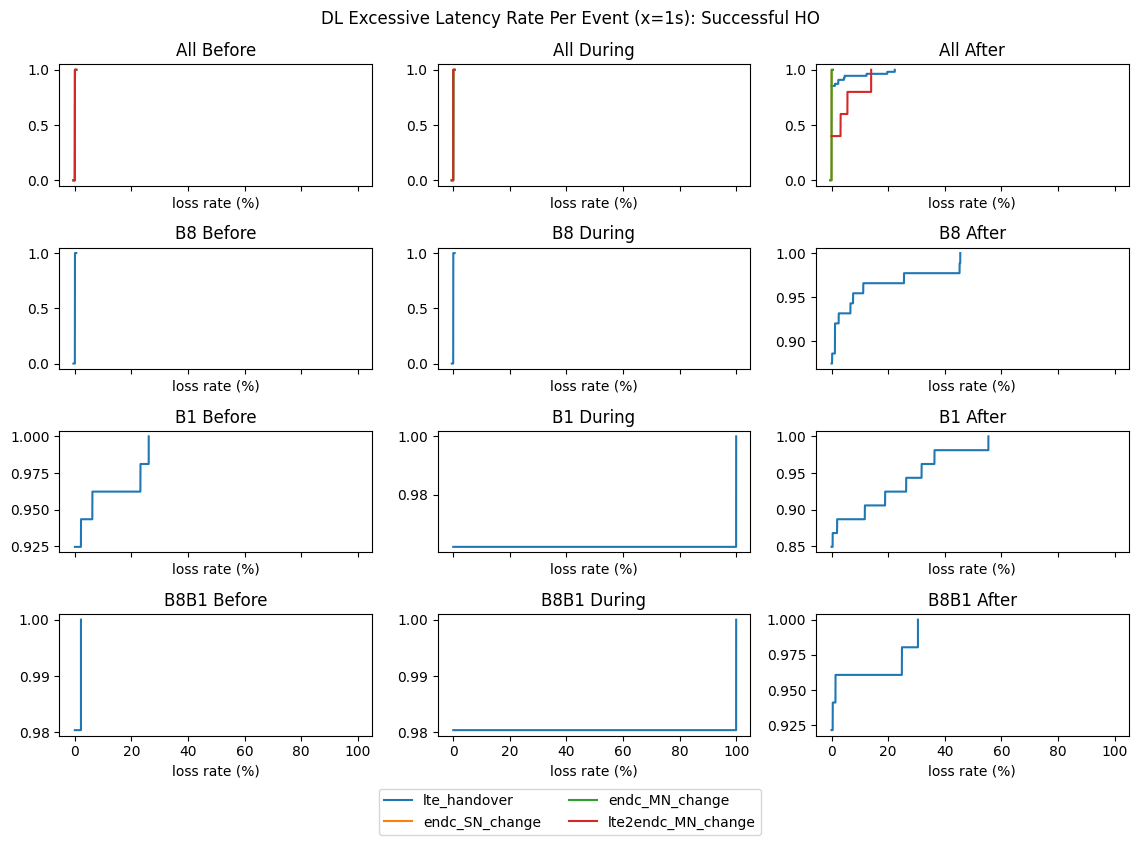

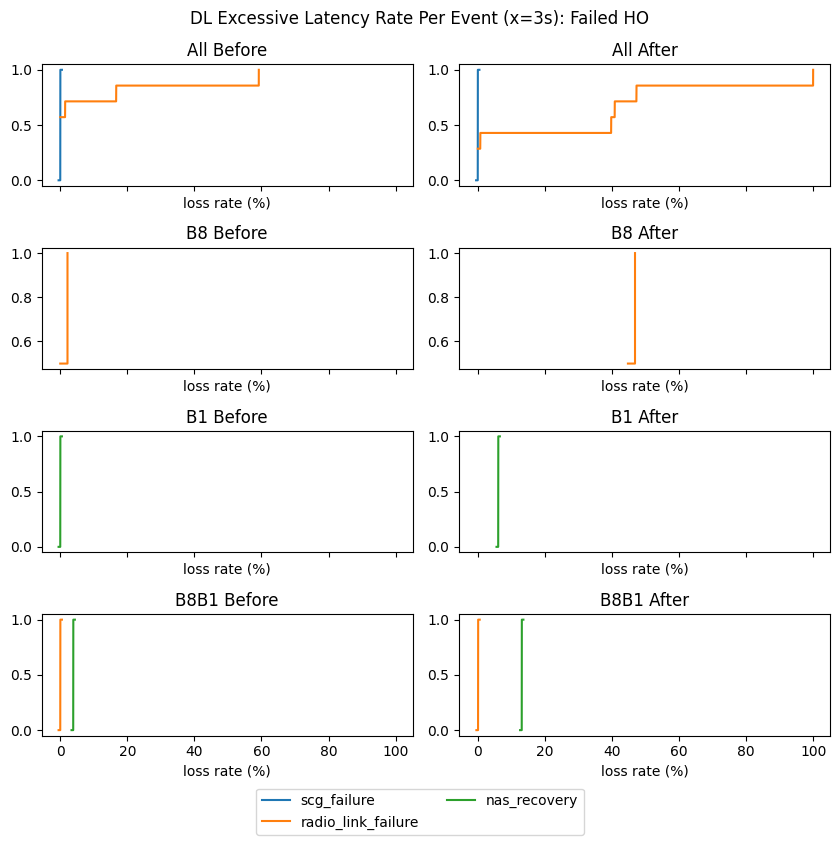

In [72]:
### ** SUCC
# fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)
# fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(11.5, 8), sharex=True)
rel = ["before", "during", "after"]
_never_occurs = set()

fig.suptitle("DL Excessive Latency Rate Per Event (x=1s): Successful HO")

labels = handover_types_0
handles = [None]*len(labels)
# cmap = plt.cm.get_cmap('gist_rainbow', len(labels))
# colors = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
# colors = list(mcolors.TABLEAU_COLORS.keys())
colors = ['tab:blue', 'tab:purple', 'tab:brown', 'tab:orange', 'tab:green', 'tab:pink', 'tab:red', 'tab:gray', 'tab:olive', 'tab:cyan']
for k, (dev, stg) in enumerate(zip(devices, setnames)):
    for i, _rel in enumerate(rel):
        ax[k, i].set_title("{} {}".format(stg, _rel).title())
        ax[k, i].set_xlabel("loss rate (%)")
        for j, type_name in enumerate(handover_types_0):
            # data = lodicts[k]["loss_num"]["after_lte_handover"]
            # event_name = "before_{}".format(type_name)
            event_name = "{}_{}".format(_rel, type_name)
            data1 = lodicts[k]["loss_num"][event_name]
            data2 = lodicts[k]["pkt_num"][event_name]
            data = [round(numer / (denom + 1e-9) * 100, 3) for numer, denom in zip(data1, data2)]
            if len(data) == 0:
                _never_occurs.add(type_name)
                continue
            # print(data)
            count, bins_count = np.histogram(data, bins=5000)
            # print(count, bins_count)
            pdf = count / sum(count)
            cdf = np.cumsum(pdf)
            # ax[k, i].plot(bins_count[1:], cdf, label=event_name)
            handles[j], = ax[k, i].plot(bins_count[1:], cdf, c=colors[j])
axbox = ax[3, 1].get_position()
# print(axbox)
labels = [item for key, item in zip(handles, labels) if key != None]
handles = [item for item in handles if item != None]
fig.legend(
    handles=handles, labels=labels,
    loc='lower center', bbox_to_anchor=[0, axbox.y0-0.17,1,1], ncol=2)
fig.tight_layout()
fig.savefig(os.path.join(figdir, "dlexcl_HO_{}.png".format(setnames[3])), bbox_inches='tight')
fig.show()
print("Never Occurs:", list(_never_occurs))

### ** FAIL
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(8.5, 8), sharex=True)
rel = ["before", "after"]
_never_occurs = set()

fig.suptitle("DL Excessive Latency Rate Per Event (x=3s): Failed HO")

labels = handover_fail_types
handles = [None]*len(labels)
# cmap = plt.cm.get_cmap('gist_rainbow', len(labels))
# colors = [mcolors.to_hex(cmap(i)) for i in range(cmap.N)]
# colors = list(mcolors.TABLEAU_COLORS.keys())
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
for k, (dev, stg) in enumerate(zip(devices, setnames)):
    for i, _rel in enumerate(rel):
        ax[k, i].set_title("{} {}".format(stg, _rel).title())
        ax[k, i].set_xlabel("loss rate (%)")
        for j, type_name in enumerate(handover_fail_types):
            # data = lodicts[k]["loss_num"]["after_lte_handover"]
            # event_name = "before_{}".format(type_name)
            event_name = "{}_{}".format(_rel, type_name)
            data1 = lodicts[k]["loss_num"][event_name]
            data2 = lodicts[k]["pkt_num"][event_name]
            data = [round(numer / (denom + 1e-9) * 100, 3) for numer, denom in zip(data1, data2)]
            if len(data) == 0:
                _never_occurs.add(type_name)
                continue
            # print(data)
            count, bins_count = np.histogram(data, bins=5000)
            # print(count, bins_count)
            pdf = count / sum(count)
            cdf = np.cumsum(pdf)
            # ax[k, i].plot(bins_count[1:], cdf, label=event_name)
            handles[j], = ax[k, i].plot(bins_count[1:], cdf, c=colors[j])
axbox = ax[3, 1].get_position()
# print(axbox)
labels = [item for key, item in zip(handles, labels) if key != None]
handles = [item for item in handles if item != None]
fig.legend(
    handles=handles, labels=labels,
    loc='lower center', bbox_to_anchor=[0, axbox.y0-0.17,1,1], ncol=2)
fig.tight_layout()
fig.savefig(os.path.join(figdir, "dlexcl_Fail_{}.png".format(setnames[3])), bbox_inches='tight')
fig.show()
print("Never Occurs:", list(_never_occurs))